# Convolutional Neural Network and Long Short-term Memory Sales Forecast

## 1.0 Business understanding

### 1.1 Literature review

### 1.2 Business objective

### 1.3 Situational assessment

## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import warnings
import holidays
from google.colab import files

In [3]:
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Conv1D, LSTM, Reshape, Dropout, BatchNormalization, Bidirectional, MaxPooling1D, Flatten
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from keras.utils import to_categorical, plot_model

#### 2.1.1 Suppress warnings

In [4]:
warnings.filterwarnings('ignore')

#### 2.1.3 Maximum rows and columns

In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### 2.1.4 Data ingestion

In [6]:
#df = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')
#test_df = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv')

In [7]:
uploaded = files.upload()

Saving train.csv to train.csv


In [8]:
file_name1 = "train.csv"

In [9]:
df=pd.read_csv(file_name1, index_col='id', parse_dates=['date'])

In [10]:
print("Dataset shape", df.shape)

Dataset shape (136950, 5)


In [11]:
df.head()

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [12]:
uploaded = files.upload()

Saving test.csv to test.csv


In [13]:
file_name1 = "test.csv"

In [14]:
df_test=pd.read_csv(file_name1, index_col='id', parse_dates=['date'])

In [15]:
print("Dataset shape", df_test.shape)

Dataset shape (27375, 4)


In [16]:
df_test.head()

,date,country,store,product
id,,,,
136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


#### 2.1.5 Data description

**High Level Data Dictionary**



In [17]:
df.columns

Index(['date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [18]:
df.describe()

,date,num_sold
count,136950,136950.000000
mean,2019-07-02 12:00:00,165.522636
min,2017-01-01 00:00:00,2.000000
25%,2018-04-02 00:00:00,46.000000
50%,2019-07-02 12:00:00,98.000000
75%,2020-10-01 00:00:00,184.000000
max,2021-12-31 00:00:00,1380.000000
std,NaN,183.691575


In [19]:
df.describe(include='object')

,country,store,product
count,136950,136950,136950
unique,5,3,5
top,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,27390,45650,27390


### 2.2 Data quality

#### 2.2.1 Check for missing values

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


There are no missing values.

#### 2.2.2 Check for outliers

In [21]:
def outlier_check(df, feature_df, rows, cols):
  num_columns = len(feature_df.columns)
  num_plots = min(rows * cols, num_columns)

  fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
  #axes = axes.flatten()

  for i, column in enumerate(feature_df.columns[:rows * cols]):
      feature_df.boxplot(column=column, ax=axes[i])
      axes[i].set_title(f'Boxplot of {column}')

  for j in range(num_plots, rows * cols):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [22]:
feature_df = df.select_dtypes(include='number')

In [23]:
rows, cols = 1, 1

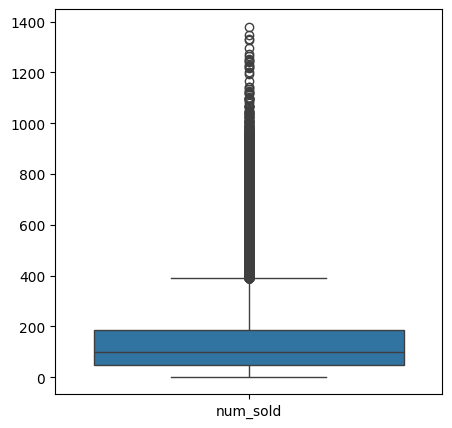

In [24]:
plt.figure(figsize=[5,5],facecolor='white')
sns.boxplot(feature_df)
plt.show()

Num_sold has outliers above 400.

#### 2.2.3 Check for duplicates

##### 2.2.3.1 Check for Flipkart duplicates

In [25]:
df.duplicated().sum()

np.int64(0)

There are no duplicate rows.

### 2.3 Exploratory data analysis

#### 2.3.1 Check sales distribution

In [26]:
def dist_sales(df, feature=None):
    sea = sns.FacetGrid(df, row=feature, height=3, aspect=5, hue=feature)
    sea.map_dataframe(sns.histplot, x="num_sold", kde=True)
    for ax in sea.axes.flat:
        ax.grid(linestyle=":")

##### 2.3.1.1 Check number sold

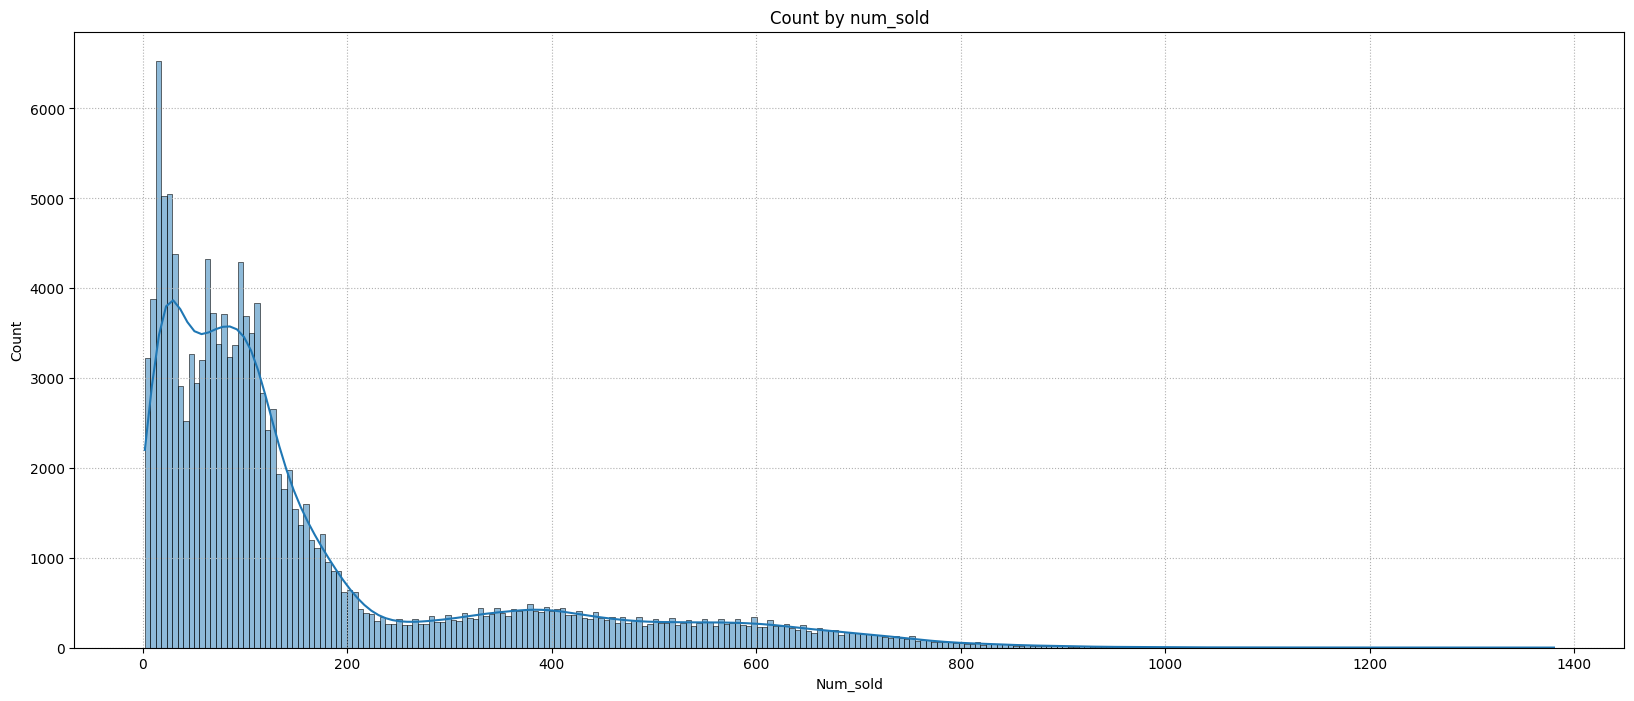

In [27]:
fig = plt.figure(figsize=(20,8))
sns.histplot(data=df, x="num_sold", kde=True)
plt.title('Count by num_sold')
plt.xlabel('Num_sold')
plt.ylabel('Count')
plt.grid(linestyle=":")

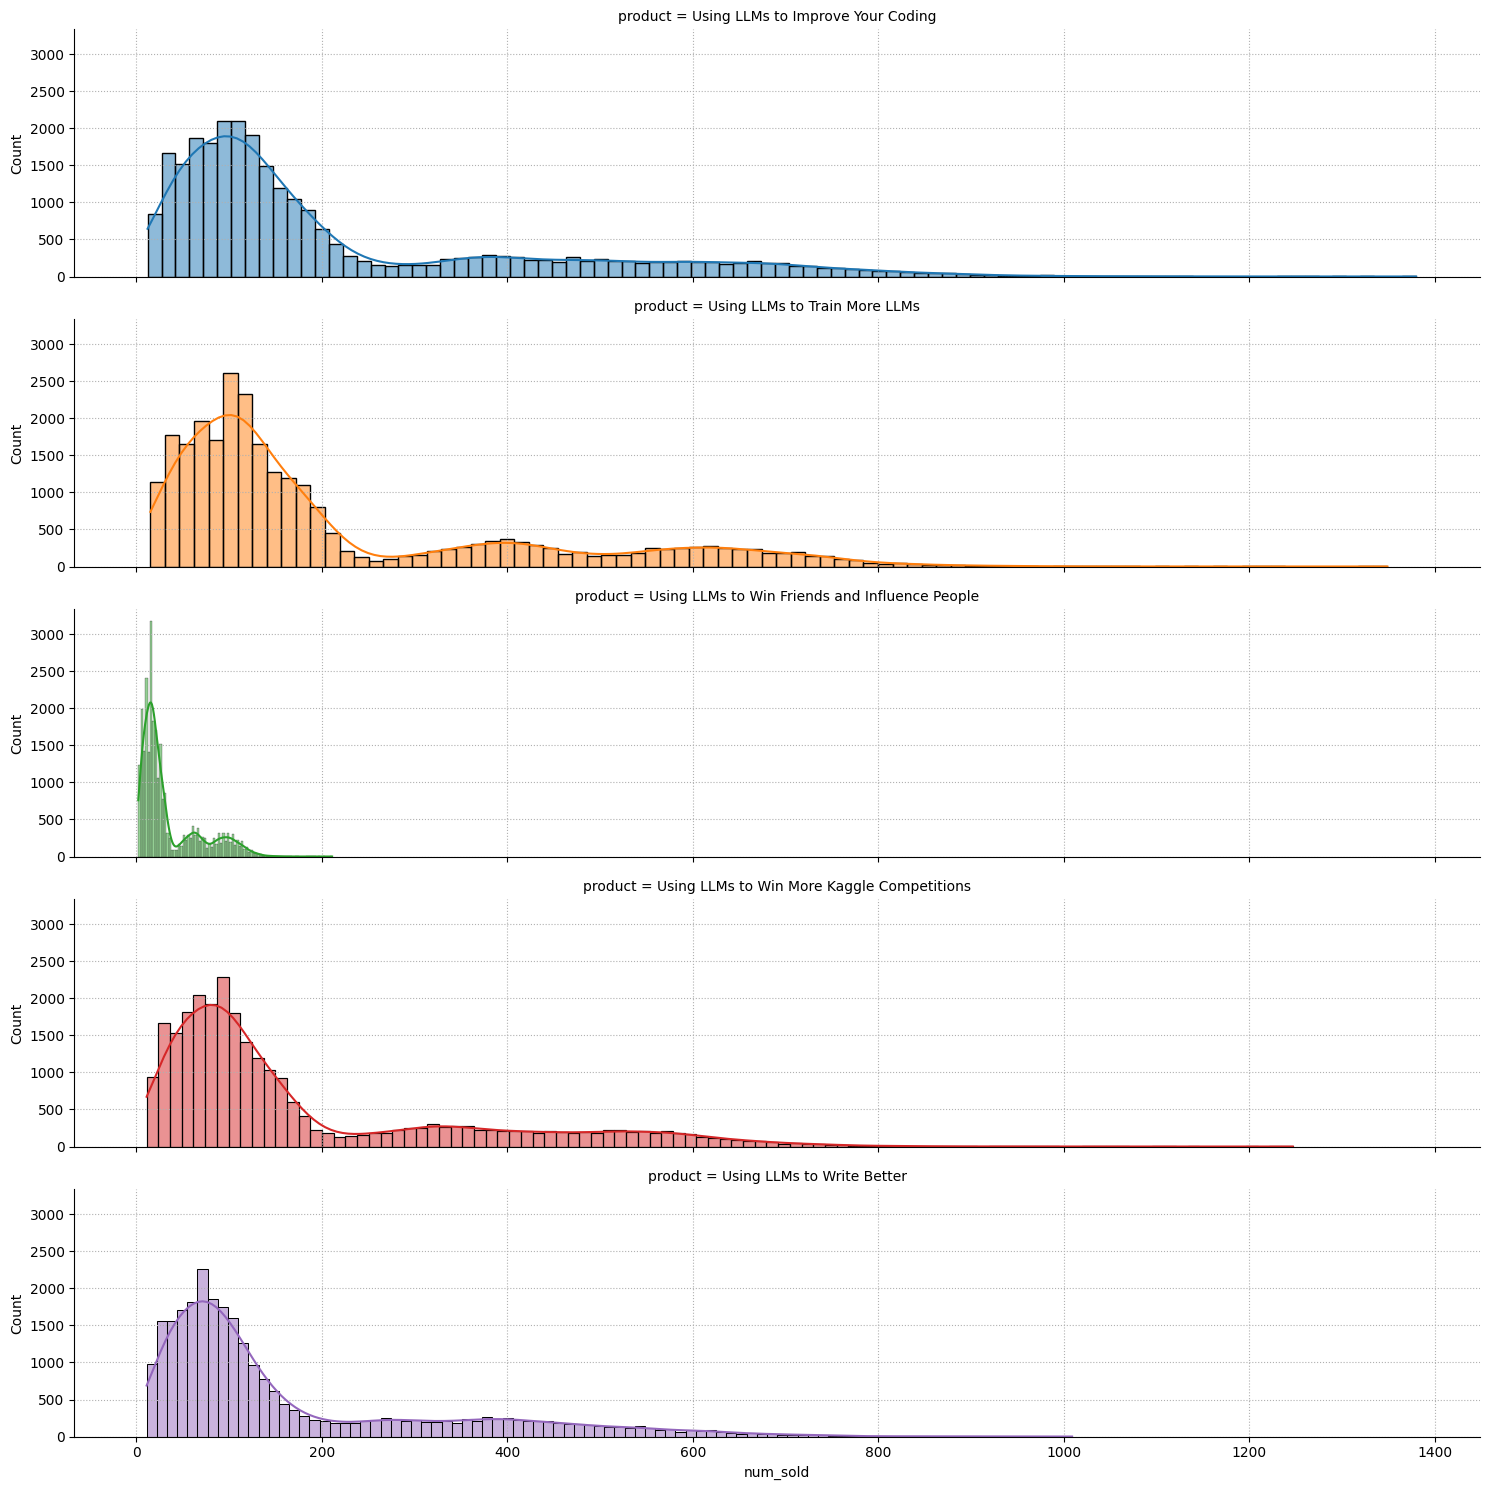

In [28]:
dist_sales(df, "product")

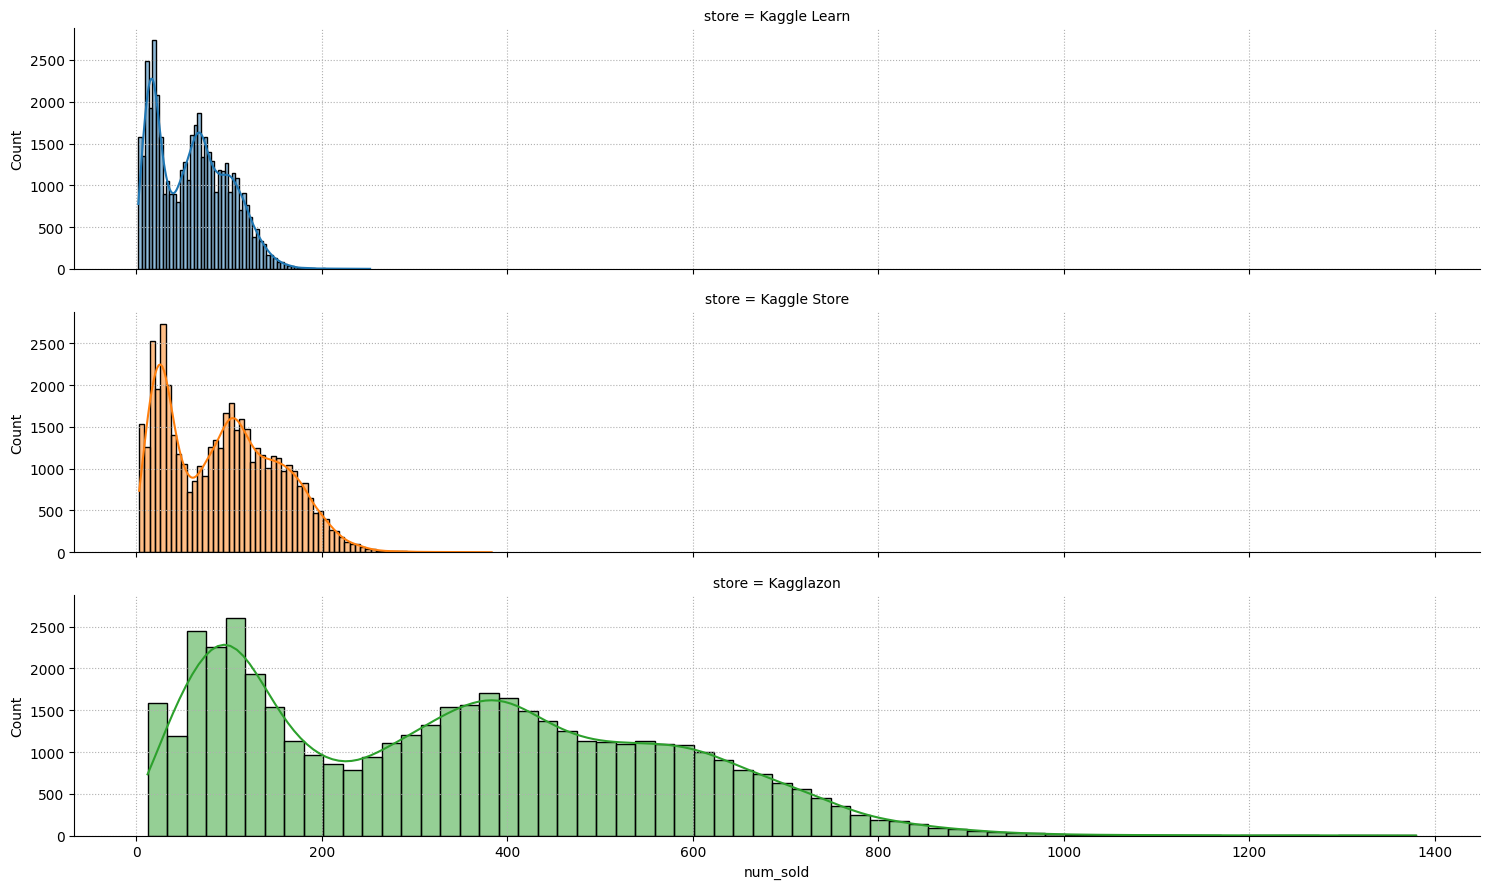

In [29]:
dist_sales(df, "store")

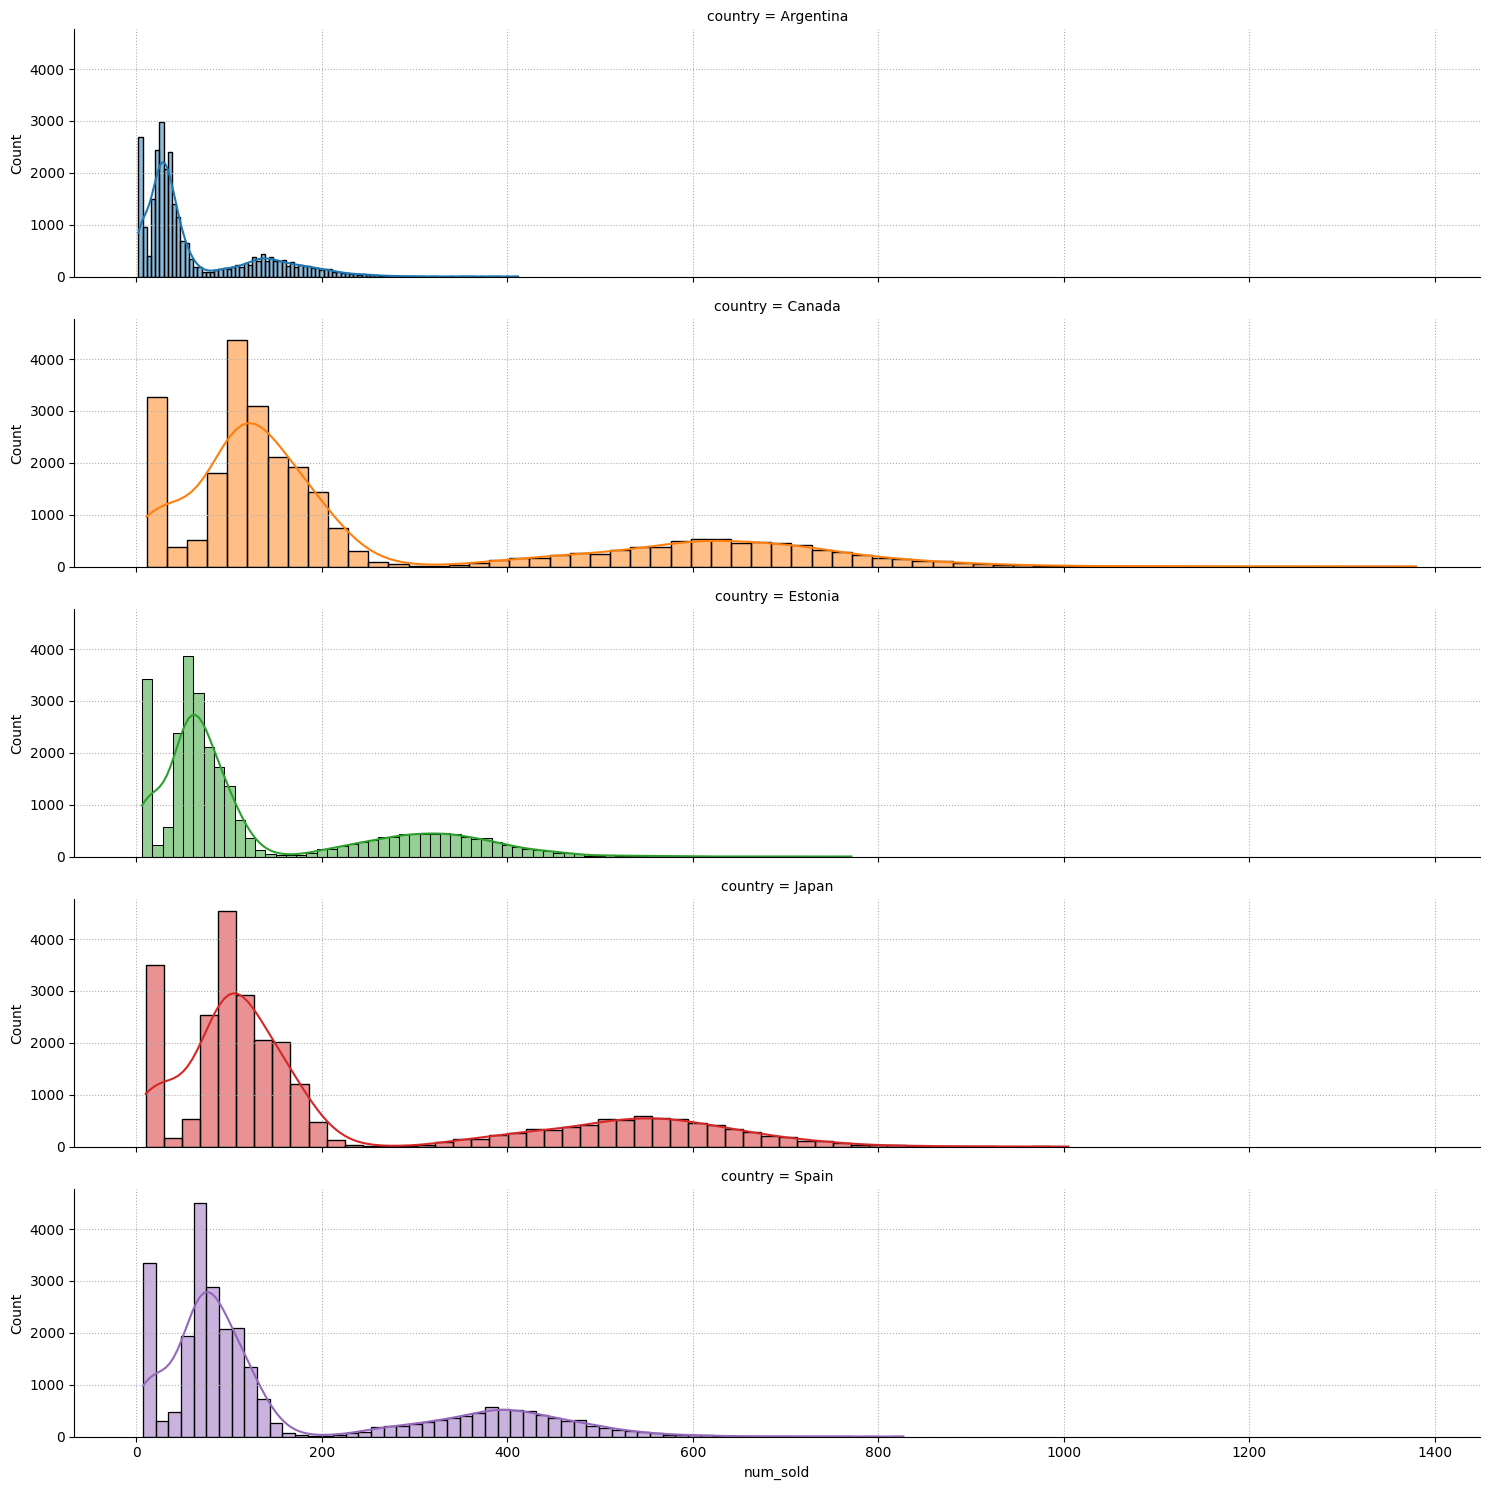

In [30]:
dist_sales(df, "country")

#### 2.3.2 Check sales timeline

In [31]:
def timeline_sales(df, feature=None):
    fig = plt.figure(figsize=(20,8))
    sns.lineplot(data=df, x="date", y="num_sold", hue=feature, errorbar = None)
    plt.grid(linestyle=":")

In [32]:
df_aux = df.groupby(["date"]).num_sold.sum()

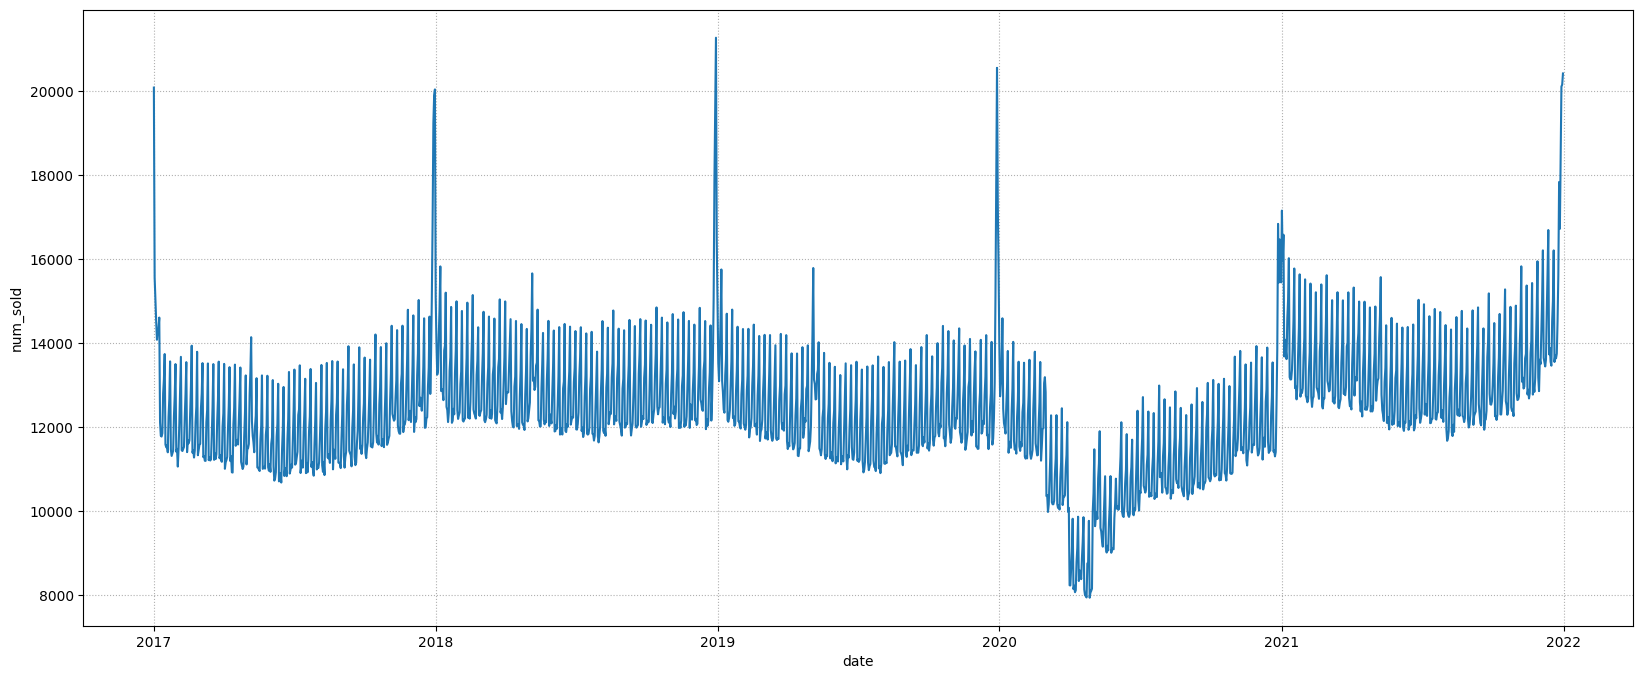

In [33]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(x=df_aux.index, y=df_aux, errorbar = None)
plt.grid(linestyle=":")

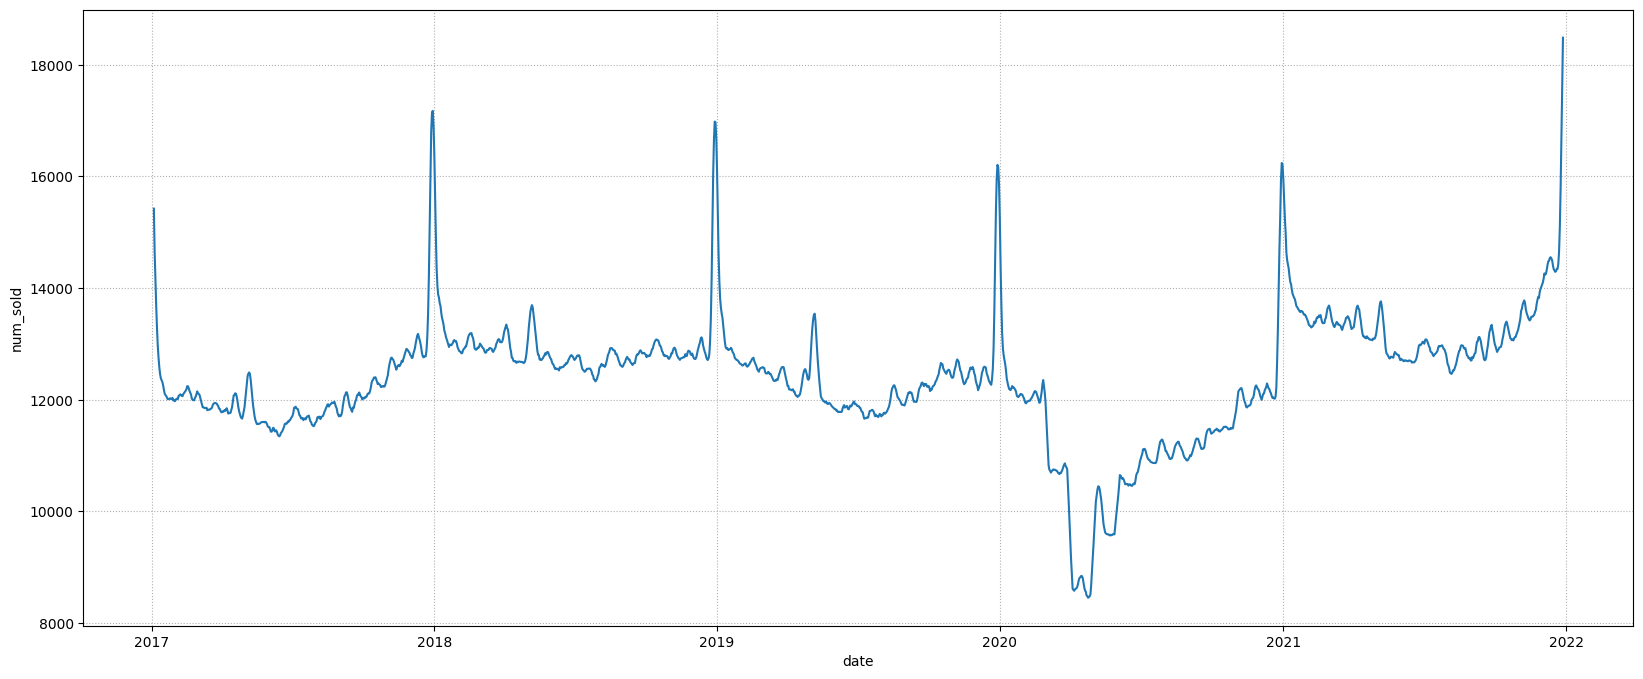

In [34]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(x=df_aux.index, y=df_aux.rolling(7).mean().shift(-3), errorbar = None)
plt.grid(linestyle=":")

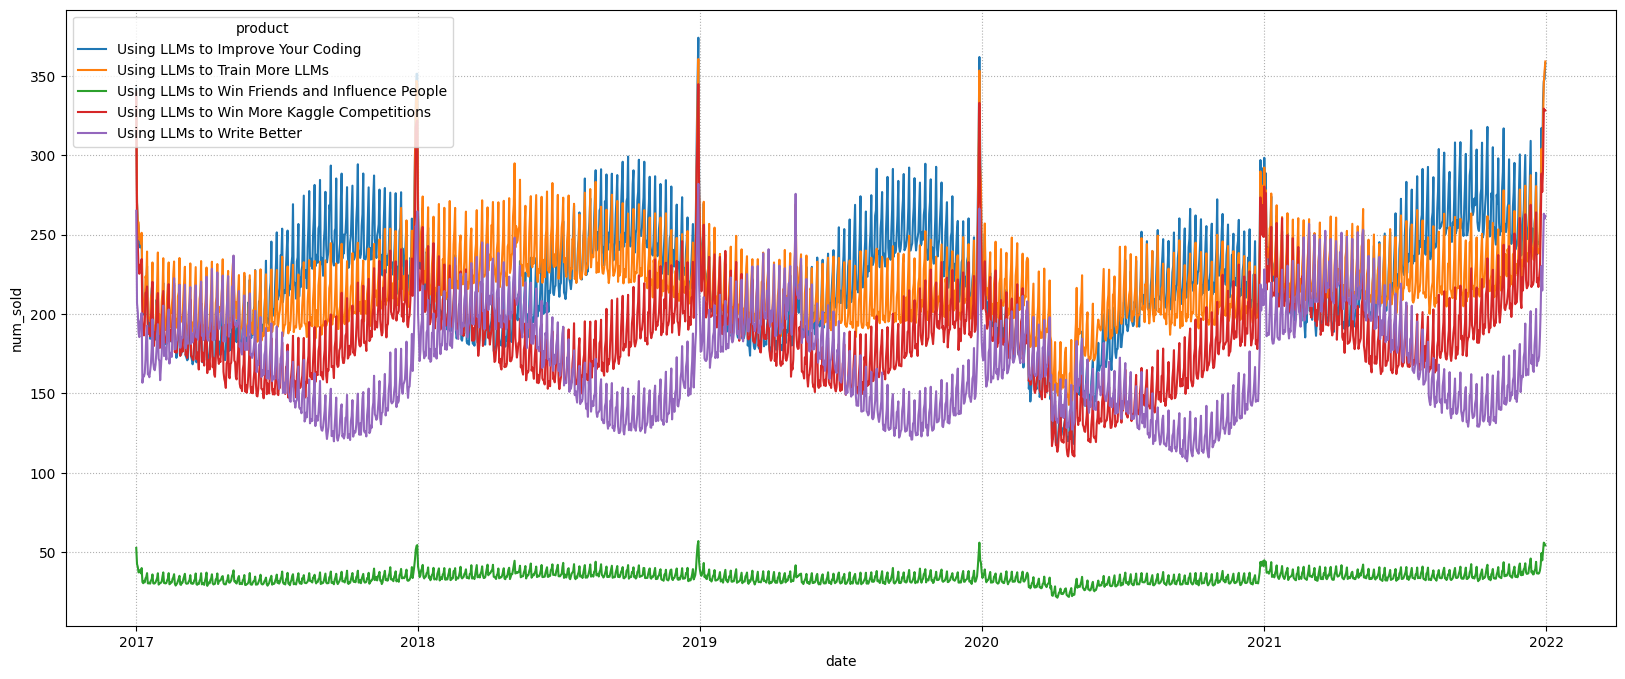

In [35]:
timeline_sales(df, "product")

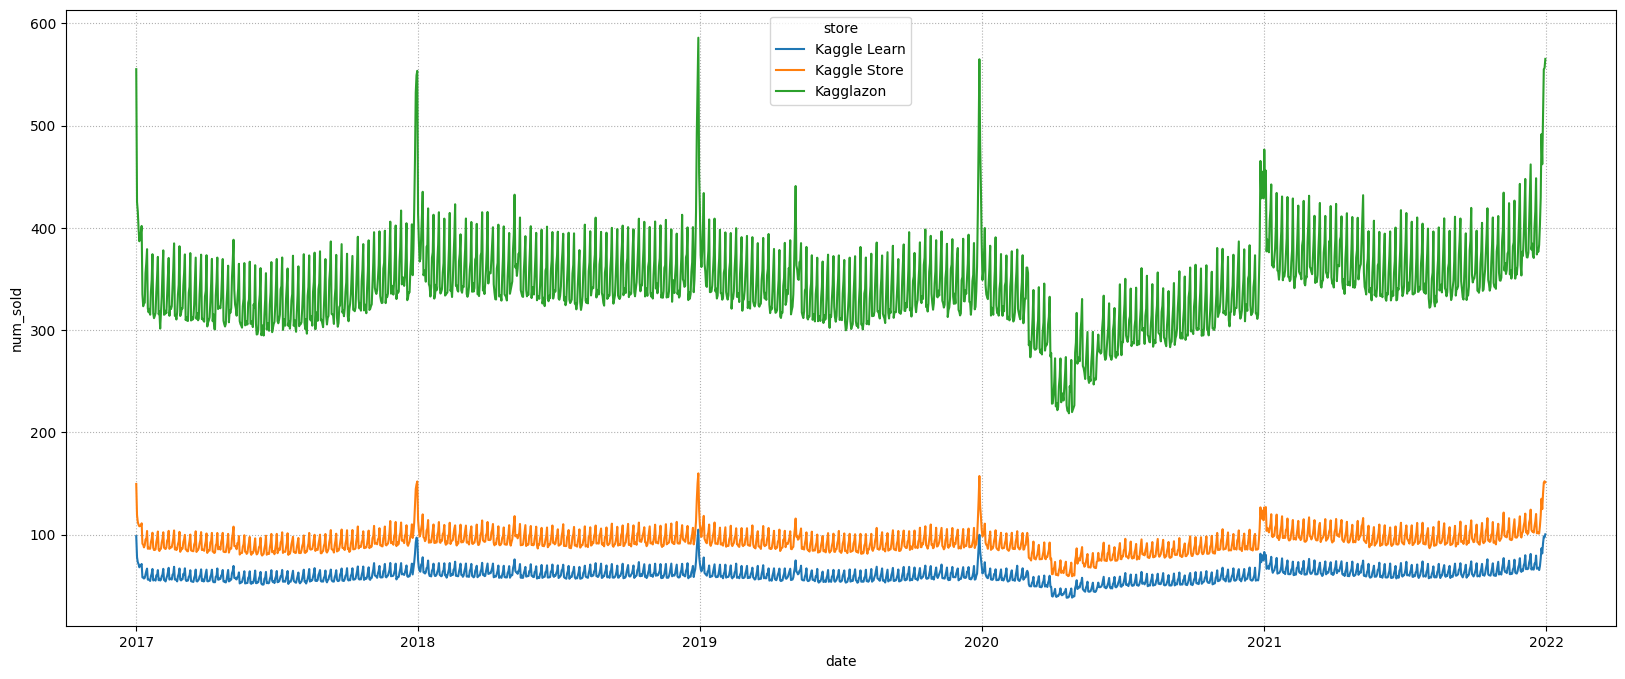

In [36]:
timeline_sales(df, "store")

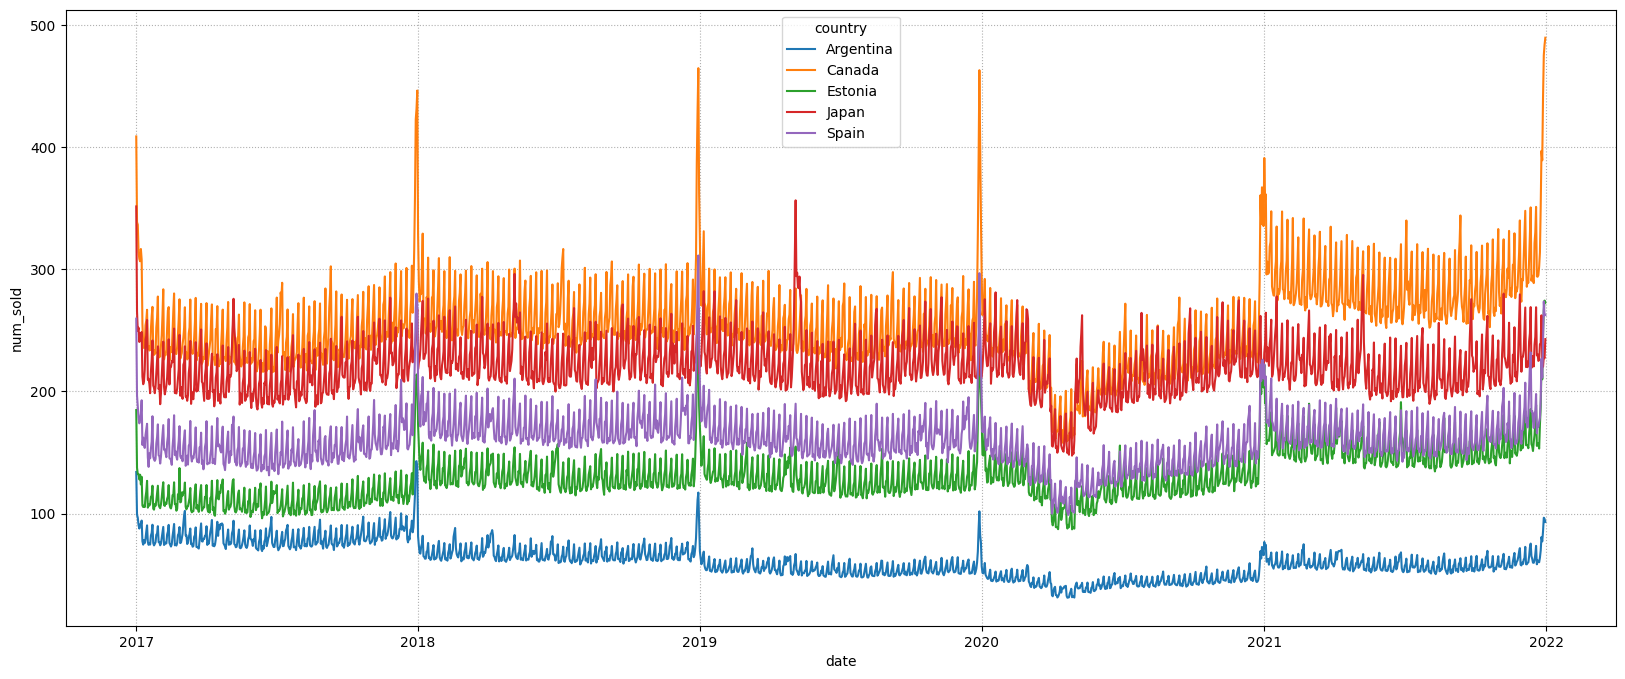

In [37]:
timeline_sales(df, "country")

#### 2.3.3 Check categorical features

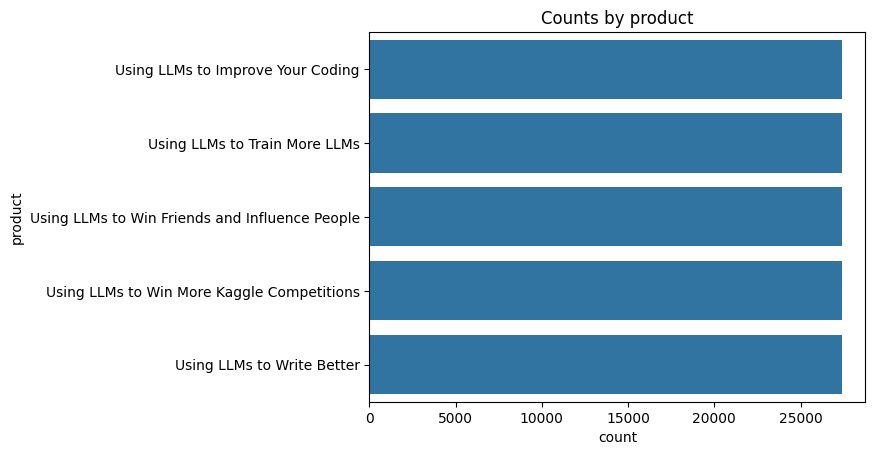

In [38]:
sns.barplot(df["product"].value_counts(), orient='h')
plt.title('Counts by product')
plt.tick_params(axis='x')
plt.show()

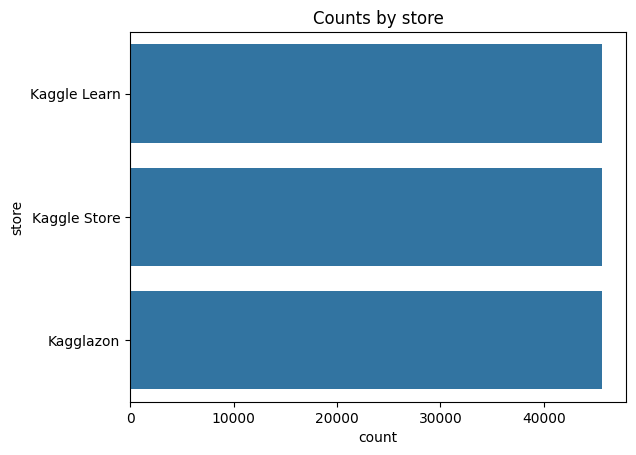

In [39]:
sns.barplot(df["store"].value_counts(), orient='h')
plt.title('Counts by store')
plt.tick_params(axis='x')
plt.show()

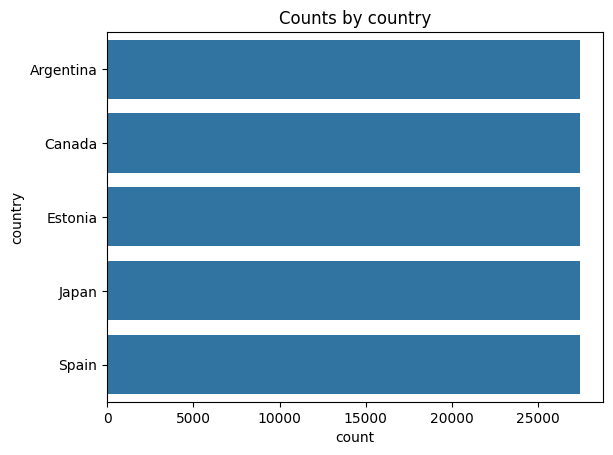

In [40]:
sns.barplot(df["country"].value_counts(), orient='h')
plt.title('Counts by country')
plt.tick_params(axis='x')
plt.show()

## 3.0 Data preprocessing

### 3.1 Data cleansing

#### 3.1.1 Drop duplicate rows

No duplicate rows.

#### 3.1.2 Drop unnecessary features

No unnecessary features.

#### 3.1.3 Remove missing values

No missing values.

### 3.2 Determine lag

In [41]:
lag = df_test["date"].unique().shape[0]
lag

365

### 3.3 Group by date

In [42]:
countries = df["country"].unique()
stores = df["store"].unique()
products = {name:f"product_{i}" for i, name in enumerate(df["product"].unique())}

In [43]:
df_date = pd.DataFrame(data={"date": df["date"].unique()})

In [44]:
col_labels = []

In [45]:
for country in countries:
    for store in stores:
        for product in products:
            num_sold = df.loc[(df["country"] == country) & (df["store"] == store) & (df["product"] == product), "num_sold"]
            col_name = country  + " " + store + " " + products[product]
            col_labels.append(col_name)
            df_date[col_name] = num_sold.values

In [46]:
df_date

,date,Argentina Kaggle Learn product_0,Argentina Kaggle Learn product_1,Argentina Kaggle Learn product_2,Argentina Kaggle Learn product_3,Argentina Kaggle Learn product_4,Argentina Kaggle Store product_0,Argentina Kaggle Store product_1,Argentina Kaggle Store product_2,Argentina Kaggle Store product_3,Argentina Kaggle Store product_4,Argentina Kagglazon product_0,Argentina Kagglazon product_1,Argentina Kagglazon product_2,Argentina Kagglazon product_3,Argentina Kagglazon product_4,Canada Kaggle Learn product_0,Canada Kaggle Learn product_1,Canada Kaggle Learn product_2,Canada Kaggle Learn product_3,Canada Kaggle Learn product_4,Canada Kaggle Store product_0,Canada Kaggle Store product_1,Canada Kaggle Store product_2,Canada Kaggle Store product_3,Canada Kaggle Store product_4,Canada Kagglazon product_0,Canada Kagglazon product_1,Canada Kagglazon product_2,Canada Kagglazon product_3,Canada Kagglazon product_4,Estonia Kaggle Learn product_0,Estonia Kaggle Learn product_1,Estonia Kaggle Learn product_2,Estonia Kaggle Learn product_3,Estonia Kaggle Learn product_4,Estonia Kaggle Store product_0,Estonia Kaggle Store product_1,Estonia Kaggle Store product_2,Estonia Kaggle Store product_3,Estonia Kaggle Store product_4,Estonia Kagglazon product_0,Estonia Kagglazon product_1,Estonia Kagglazon product_2,Estonia Kagglazon product_3,Estonia Kagglazon product_4,Japan Kaggle Learn product_0,Japan Kaggle Learn product_1,Japan Kaggle Learn product_2,Japan Kaggle Learn product_3,Japan Kaggle Learn product_4,Japan Kaggle Store product_0,Japan Kaggle Store product_1,Japan Kaggle Store product_2,Japan Kaggle Store product_3,Japan Kaggle Store product_4,Japan Kagglazon product_0,Japan Kagglazon product_1,Japan Kagglazon product_2,Japan Kagglazon product_3,Japan Kagglazon product_4,Spain Kaggle Learn product_0,Spain Kaggle Learn product_1,Spain Kaggle Learn product_2,Spain Kaggle Learn product_3,Spain Kaggle Learn product_4,Spain Kaggle Store product_0,Spain Kaggle Store product_1,Spain Kaggle Store product_2,Spain Kaggle Store product_3,Spain Kaggle Store product_4,Spain Kagglazon product_0,Spain Kagglazon product_1,Spain Kagglazon product_2,Spain Kagglazon product_3,Spain Kagglazon product_4
0,2017-01-01,63,66,9,59,49,88,98,14,83,69,340,371,53,364,285,202,199,31,202,138,274,288,47,268,249,1041,1101,166,1062,866,92,89,14,81,70,132,129,19,137,106,501,481,70,468,383,167,162,26,163,119,270,246,39,266,191,938,869,147,970,701,122,125,20,106,90,177,198,29,184,139,724,681,107,673,520
1,2017-01-02,51,47,7,43,35,74,77,11,70,55,250,273,52,236,206,156,150,26,158,123,253,240,46,252,205,870,930,141,814,717,63,65,10,64,50,109,102,15,88,80,353,347,64,366,286,142,146,19,121,93,210,192,30,180,146,728,703,105,621,547,106,100,13,94,68,145,140,22,125,110,541,546,78,481,381
2,2017-01-03,44,45,7,41,37,64,68,11,67,56,267,253,35,252,201,147,155,26,149,123,235,240,38,222,187,875,967,135,830,720,64,63,10,60,50,105,92,15,89,72,354,355,56,310,289,123,118,18,120,98,191,176,31,164,150,673,631,115,640,494,85,90,14,80,60,161,133,20,118,106,499,489,80,509,372
3,2017-01-04,44,42,7,40,32,72,66,10,64,49,236,243,34,224,194,158,169,24,137,113,236,244,40,224,179,799,895,122,751,619,64,61,9,58,49,93,99,15,94,75,376,369,57,315,251,124,122,18,108,97,176,186,29,159,141,719,688,93,635,489,79,76,13,69,69,128,121,19,126,99,524,485,70,435,367
4,2017-01-05,40,46,6,39,32,66,61,10,64,50,247,231,38,207,179,140,139,24,138,117,239,253,35,214,185,837,817,134,762,595,60,62,9,54,45,97,90,13,80,78,360,342,52,324,254,116,113,17,104,90,160,186,30,163,138,616,672,101,592,511,80,83,12,77,60,122,129,20,118,104,469,478,69,444,344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2021-12-27,41,34,5,33,28,54,60,9,43,42,220,206,29,204,150,185,183,29,183,

### 3.4 Analyze seasonality

In [47]:
def ADF2pd(df, label_columns, columns=None, transform=False, n=1):
    cols = ["Time Series", "ADF Statistic", "p_value", "Reject_H0", "Conclusion"]
    df_ADF = pd.DataFrame(columns=cols)

    for col in label_columns:
        timeseries = df.loc[:, col]

        if transform == True:
            timeseries = np.diff(timeseries, n=n)

        ADF_result = adfuller(timeseries)
        rejectionH0 = "Yes" if ADF_result[1] < 0.05 else "No"
        conclusion = "Stationary" if ADF_result[1] < 0.05 else "Not stationary"

        values = [col] + [ADF_result[0], ADF_result[1], rejectionH0, conclusion]

        row = pd.DataFrame(data={k:[v] for (k, v) in zip(cols, values)})
        df_ADF = pd.concat([df_ADF, row], ignore_index=True)
    return df_ADF

In [48]:
df_adf = ADF2pd(df_date, col_labels)

In [49]:
df_adf

,Time Series,ADF Statistic,p_value,Reject_H0,Conclusion
0,Argentina Kaggle Learn product_0,-1.661765,0.450912,No,Not stationary
1,Argentina Kaggle Learn product_1,-1.776544,0.392168,No,Not stationary
2,Argentina Kaggle Learn product_2,-2.003774,0.284921,No,Not stationary
3,Argentina Kaggle Learn product_3,-1.949714,0.309047,No,Not stationary
4,Argentina Kaggle Learn product_4,-1.972129,0.298926,No,Not stationary
5,Argentina Kaggle Store product_0,-1.604019,0.481574,No,Not stationary
6,Argentina Kaggle Store product_1,-1.790581,0.385148,No,Not stationary
7,Argentina Kaggle Store product_2,-1.947201,0.310192,No,Not stationary
8,Argentina Kaggle Store product_3,-1.965915,0.301715,No,Not stationary
9,Argentina Kaggle Store product_4,-1.905270,0.329586,No,Not stationary


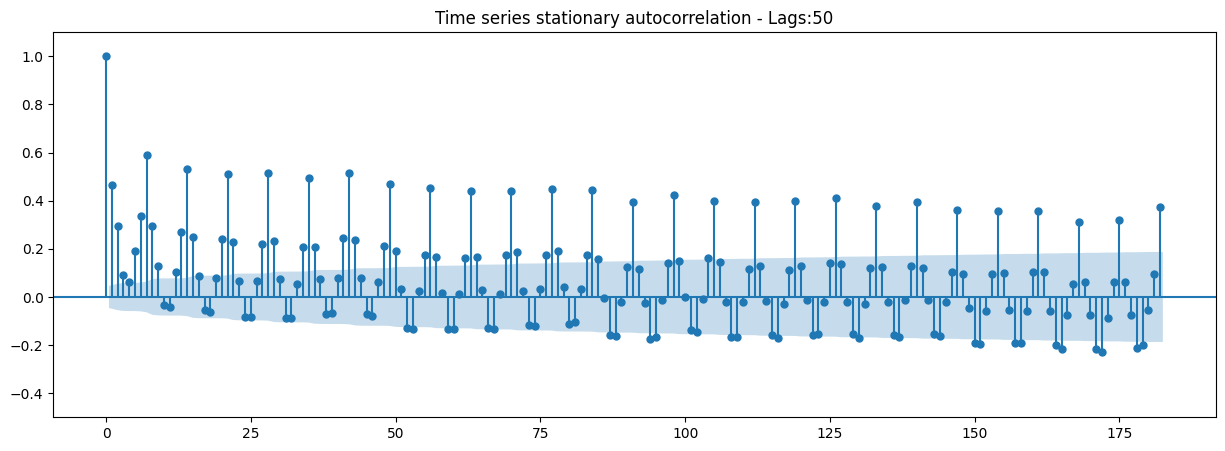

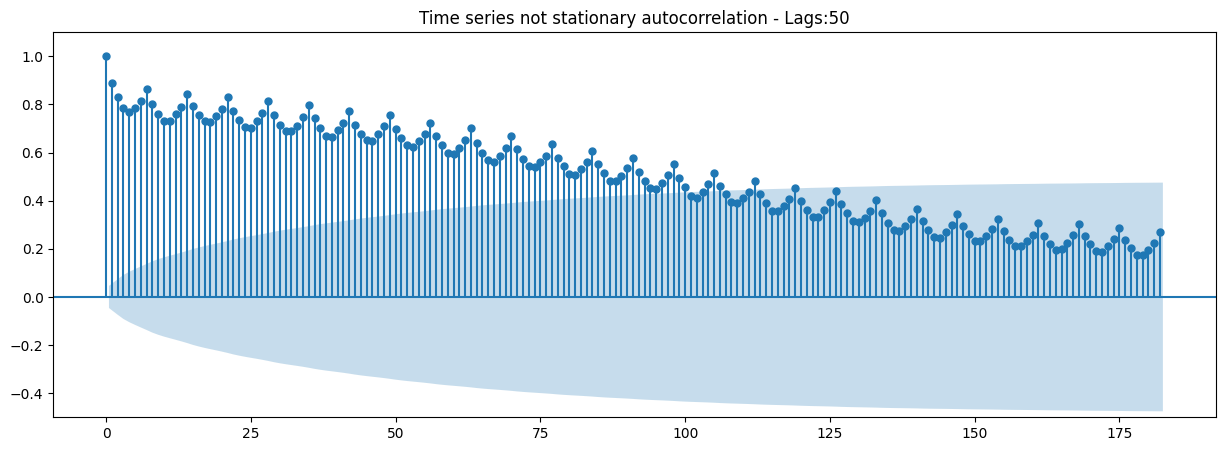

In [50]:
for i, key in enumerate([df_adf.loc[47, "Time Series"], df_adf.loc[0, "Time Series"]]):
    timeseries = df_date.loc[:, key]

    fig, ax = plt.subplots(figsize=(15, 5))
    plot_acf(timeseries, lags=lag//2, ax=ax)

    title = "stationary" if i == 0 else "not stationary"
    ax.set_ylim((-0.5, 1.1))
    ax.set_title(f"Time series {title} autocorrelation - Lags:50")

In [51]:
df_adf = ADF2pd(df_date, col_labels, transform=True)
df_adf

,Time Series,ADF Statistic,p_value,Reject_H0,Conclusion
0,Argentina Kaggle Learn product_0,-11.380655,8.527754e-21,Yes,Stationary
1,Argentina Kaggle Learn product_1,-11.985026,3.629992e-22,Yes,Stationary
2,Argentina Kaggle Learn product_2,-12.597494,1.765666e-23,Yes,Stationary
3,Argentina Kaggle Learn product_3,-11.009278,6.385974e-20,Yes,Stationary
4,Argentina Kaggle Learn product_4,-11.062348,4.774528e-20,Yes,Stationary
5,Argentina Kaggle Store product_0,-12.000257,3.359487e-22,Yes,Stationary
6,Argentina Kaggle Store product_1,-12.700520,1.082442e-23,Yes,Stationary
7,Argentina Kaggle Store product_2,-12.888693,4.496561e-24,Yes,Stationary
8,Argentina Kaggle Store product_3,-11.940498,4.555115e-22,Yes,Stationary
9,Argentina Kaggle Store product_4,-11.122538,3.437295e-20,Yes,Stationary


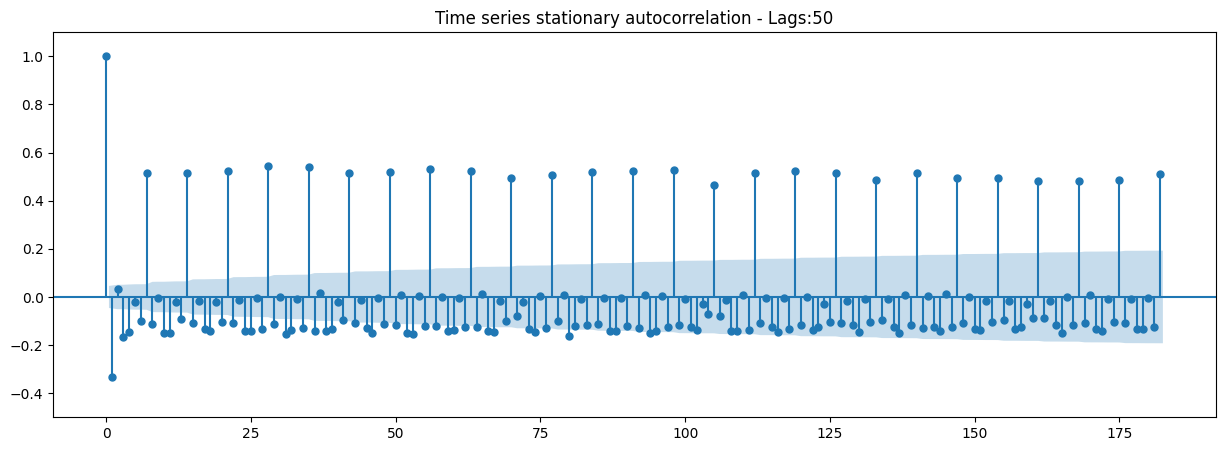

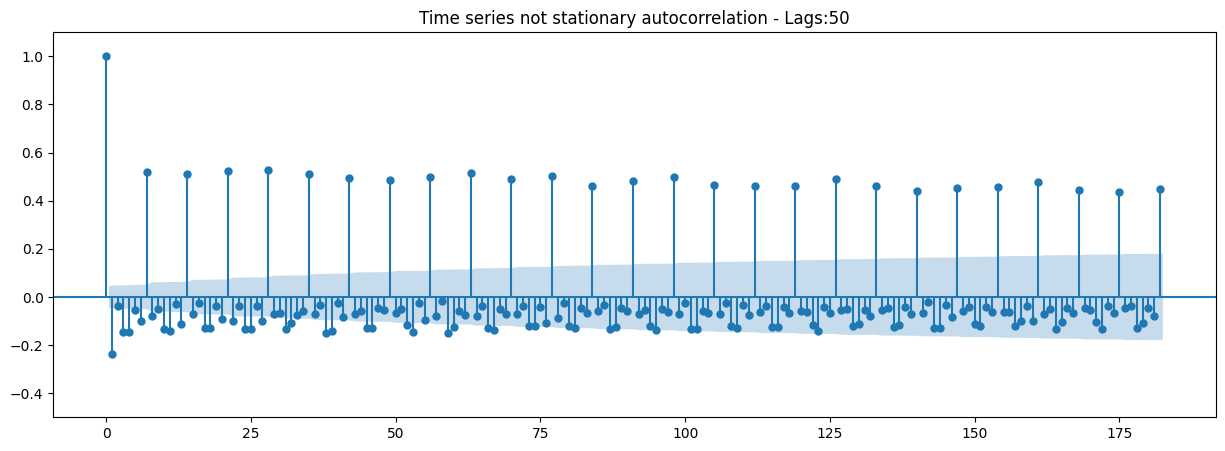

In [52]:
for i, key in enumerate([df_adf.loc[47, "Time Series"], df_adf.loc[0, "Time Series"]]):
    timeseries = df_date.loc[:, key]
    timeseries = np.diff(timeseries, n=1)

    fig, ax = plt.subplots(figsize=(15, 5))
    plot_acf(timeseries, lags=lag//2, ax=ax)

    title = "stationary" if i == 0 else "not stationary"
    ax.set_ylim((-0.5, 1.1))
    ax.set_title(f"Time series {title} autocorrelation - Lags:50")

### 3.5 Feature engineering

#### 3.5.1 Identify holidays

In [53]:
def country_holidays(country, start, end):
    holiday_days = holidays.CountryHoliday(country)
    date_range = pd.date_range(start, end)
    return [date for date in date_range if date in holiday_days]

#### 3.5.2 Breakdown dates

In [54]:
df_date["year"] = df_date["date"].dt.year
df_date["month"] = df_date["date"].dt.month
df_date["day"] = df_date["date"].dt.day
df_date["week"] = df_date["date"].dt.dayofweek
df_date["dayofweek"] = df_date["date"].dt.dayofweek
df_date["dayofyear"] = df_date["date"].dt.dayofyear
df_date["quarter"] = df_date["date"].dt.dayofweek
df_date["is_weekend"] = df_date["date"].dt.dayofweek > 4

In [55]:
for country in countries:
    df_date[country+" holiday"] = False
    df_date.loc[(df_date["date"].isin(country_holidays(country, df_date["date"].min(), df_date["date"].max()))), country+" holiday"] = True

In [56]:
df_date

,date,Argentina Kaggle Learn product_0,Argentina Kaggle Learn product_1,Argentina Kaggle Learn product_2,Argentina Kaggle Learn product_3,Argentina Kaggle Learn product_4,Argentina Kaggle Store product_0,Argentina Kaggle Store product_1,Argentina Kaggle Store product_2,Argentina Kaggle Store product_3,Argentina Kaggle Store product_4,Argentina Kagglazon product_0,Argentina Kagglazon product_1,Argentina Kagglazon product_2,Argentina Kagglazon product_3,Argentina Kagglazon product_4,Canada Kaggle Learn product_0,Canada Kaggle Learn product_1,Canada Kaggle Learn product_2,Canada Kaggle Learn product_3,Canada Kaggle Learn product_4,Canada Kaggle Store product_0,Canada Kaggle Store product_1,Canada Kaggle Store product_2,Canada Kaggle Store product_3,Canada Kaggle Store product_4,Canada Kagglazon product_0,Canada Kagglazon product_1,Canada Kagglazon product_2,Canada Kagglazon product_3,Canada Kagglazon product_4,Estonia Kaggle Learn product_0,Estonia Kaggle Learn product_1,Estonia Kaggle Learn product_2,Estonia Kaggle Learn product_3,Estonia Kaggle Learn product_4,Estonia Kaggle Store product_0,Estonia Kaggle Store product_1,Estonia Kaggle Store product_2,Estonia Kaggle Store product_3,Estonia Kaggle Store product_4,Estonia Kagglazon product_0,Estonia Kagglazon product_1,Estonia Kagglazon product_2,Estonia Kagglazon product_3,Estonia Kagglazon product_4,Japan Kaggle Learn product_0,Japan Kaggle Learn product_1,Japan Kaggle Learn product_2,Japan Kaggle Learn product_3,Japan Kaggle Learn product_4,Japan Kaggle Store product_0,Japan Kaggle Store product_1,Japan Kaggle Store product_2,Japan Kaggle Store product_3,Japan Kaggle Store product_4,Japan Kagglazon product_0,Japan Kagglazon product_1,Japan Kagglazon product_2,Japan Kagglazon product_3,Japan Kagglazon product_4,Spain Kaggle Learn product_0,Spain Kaggle Learn product_1,Spain Kaggle Learn product_2,Spain Kaggle Learn product_3,Spain Kaggle Learn product_4,Spain Kaggle Store product_0,Spain Kaggle Store product_1,Spain Kaggle Store product_2,Spain Kaggle Store product_3,Spain Kaggle Store product_4,Spain Kagglazon product_0,Spain Kagglazon product_1,Spain Kagglazon product_2,Spain Kagglazon product_3,Spain Kagglazon product_4,year,month,day,week,dayofweek,dayofyear,quarter,is_weekend,Argentina holiday,Canada holiday,Estonia holiday,Japan holiday,Spain holiday
0,2017-01-01,63,66,9,59,49,88,98,14,83,69,340,371,53,364,285,202,199,31,202,138,274,288,47,268,249,1041,1101,166,1062,866,92,89,14,81,70,132,129,19,137,106,501,481,70,468,383,167,162,26,163,119,270,246,39,266,191,938,869,147,970,701,122,125,20,106,90,177,198,29,184,139,724,681,107,673,520,2017,1,1,6,6,1,6,True,True,True,True,True,False
1,2017-01-02,51,47,7,43,35,74,77,11,70,55,250,273,52,236,206,156,150,26,158,123,253,240,46,252,205,870,930,141,814,717,63,65,10,64,50,109,102,15,88,80,353,347,64,366,286,142,146,19,121,93,210,192,30,180,146,728,703,105,621,547,106,100,13,94,68,145,140,22,125,110,541,546,78,481,381,2017,1,2,0,0,2,0,False,False,True,False,True,False
2,2017-01-03,44,45,7,41,37,64,68,11,67,56,267,253,35,252,201,147,155,26,149,123,235,240,38,222,187,875,967,135,830,720,64,63,10,60,50,105,92,15,89,72,354,355,56,310,289,123,118,18,120,98,191,176,31,164,150,673,631,115,640,494,85,90,14,80,60,161,133,20,118,106,499,489,80,509,372,2017,1,3,1,1,3,1,False,False,False,False,False,False
3,2017-01-04,44,42,7,40,32,72,66,10,64,49,236,243,34,224,194,158,169,24,137,113,236,244,40,224,179,799,895,122,751,619,64,61,9,58,49,93,99,15,94,75,376,369,57,315,251,124,122,18,108,97,176,186,29,159,141,719,688,93,635,489,79,76,13,69,69,128,121,19,126,99,524,485,70,435,367,2017,1,4,2,2,4,2,False,False,False,False,False,False
4,2017-01-05,40,46,6,39,32,66,61,10,64,50,247,231,38,207,179,140,139,24,138,117,239,253,35,214,185,837,817,134,762,595,60,62,9,54,45,97,90,13,80,78,360,342,52,324,254,116,113,17,104,90,160,186,30,163,138,616,672,101,592,511,80,83,12,77,60,122,129,20,118,104,469,478,69,444,344,2017,1,5,3,3,5,3,False,False,False,False,Fals

### 3.3 Data partitioning

#### 3.3.1 Testing split (2021)

In [57]:
test_index = df_date.loc[df_date["date"].dt.year == 2021].index.tolist()
test_df = df_date.loc[[test_index[0]-1] + test_index].drop(["date"], axis=1)
raw_test_df = test_df.copy()

#### 3.3.2 Validation split (2020)

In [58]:
val_index = df_date.loc[df_date["date"].dt.year == 2020].index.tolist()
val_df = df_date.loc[[val_index[0]-1] + val_index].drop(["date"], axis=1)
raw_val_df = val_df.copy()

#### 3.3.3 Training split (2017-19)

In [59]:
train_df = df_date.iloc[0:val_df.index[0]].drop(["date"], axis=1)
raw_train_df = train_df.copy()
train_df

,Argentina Kaggle Learn product_0,Argentina Kaggle Learn product_1,Argentina Kaggle Learn product_2,Argentina Kaggle Learn product_3,Argentina Kaggle Learn product_4,Argentina Kaggle Store product_0,Argentina Kaggle Store product_1,Argentina Kaggle Store product_2,Argentina Kaggle Store product_3,Argentina Kaggle Store product_4,Argentina Kagglazon product_0,Argentina Kagglazon product_1,Argentina Kagglazon product_2,Argentina Kagglazon product_3,Argentina Kagglazon product_4,Canada Kaggle Learn product_0,Canada Kaggle Learn product_1,Canada Kaggle Learn product_2,Canada Kaggle Learn product_3,Canada Kaggle Learn product_4,Canada Kaggle Store product_0,Canada Kaggle Store product_1,Canada Kaggle Store product_2,Canada Kaggle Store product_3,Canada Kaggle Store product_4,Canada Kagglazon product_0,Canada Kagglazon product_1,Canada Kagglazon product_2,Canada Kagglazon product_3,Canada Kagglazon product_4,Estonia Kaggle Learn product_0,Estonia Kaggle Learn product_1,Estonia Kaggle Learn product_2,Estonia Kaggle Learn product_3,Estonia Kaggle Learn product_4,Estonia Kaggle Store product_0,Estonia Kaggle Store product_1,Estonia Kaggle Store product_2,Estonia Kaggle Store product_3,Estonia Kaggle Store product_4,Estonia Kagglazon product_0,Estonia Kagglazon product_1,Estonia Kagglazon product_2,Estonia Kagglazon product_3,Estonia Kagglazon product_4,Japan Kaggle Learn product_0,Japan Kaggle Learn product_1,Japan Kaggle Learn product_2,Japan Kaggle Learn product_3,Japan Kaggle Learn product_4,Japan Kaggle Store product_0,Japan Kaggle Store product_1,Japan Kaggle Store product_2,Japan Kaggle Store product_3,Japan Kaggle Store product_4,Japan Kagglazon product_0,Japan Kagglazon product_1,Japan Kagglazon product_2,Japan Kagglazon product_3,Japan Kagglazon product_4,Spain Kaggle Learn product_0,Spain Kaggle Learn product_1,Spain Kaggle Learn product_2,Spain Kaggle Learn product_3,Spain Kaggle Learn product_4,Spain Kaggle Store product_0,Spain Kaggle Store product_1,Spain Kaggle Store product_2,Spain Kaggle Store product_3,Spain Kaggle Store product_4,Spain Kagglazon product_0,Spain Kagglazon product_1,Spain Kagglazon product_2,Spain Kagglazon product_3,Spain Kagglazon product_4,year,month,day,week,dayofweek,dayofyear,quarter,is_weekend,Argentina holiday,Canada holiday,Estonia holiday,Japan holiday,Spain holiday
0,63,66,9,59,49,88,98,14,83,69,340,371,53,364,285,202,199,31,202,138,274,288,47,268,249,1041,1101,166,1062,866,92,89,14,81,70,132,129,19,137,106,501,481,70,468,383,167,162,26,163,119,270,246,39,266,191,938,869,147,970,701,122,125,20,106,90,177,198,29,184,139,724,681,107,673,520,2017,1,1,6,6,1,6,True,True,True,True,True,False
1,51,47,7,43,35,74,77,11,70,55,250,273,52,236,206,156,150,26,158,123,253,240,46,252,205,870,930,141,814,717,63,65,10,64,50,109,102,15,88,80,353,347,64,366,286,142,146,19,121,93,210,192,30,180,146,728,703,105,621,547,106,100,13,94,68,145,140,22,125,110,541,546,78,481,381,2017,1,2,0,0,2,0,False,False,True,False,True,False
2,44,45,7,41,37,64,68,11,67,56,267,253,35,252,201,147,155,26,149,123,235,240,38,222,187,875,967,135,830,720,64,63,10,60,50,105,92,15,89,72,354,355,56,310,289,123,118,18,120,98,191,176,31,164,150,673,631,115,640,494,85,90,14,80,60,161,133,20,118,106,499,489,80,509,372,2017,1,3,1,1,3,1,False,False,False,False,False,False
3,44,42,7,40,32,72,66,10,64,49,236,243,34,224,194,158,169,24,137,113,236,244,40,224,179,799,895,122,751,619,64,61,9,58,49,93,99,15,94,75,376,369,57,315,251,124,122,18,108,97,176,186,29,159,141,719,688,93,635,489,79,76,13,69,69,128,121,19,126,99,524,485,70,435,367,2017,1,4,2,2,4,2,False,False,False,False,False,False
4,40,46,6,39,32,66,61,10,64,50,247,231,38,207,179,140,139,24,138,117,239,253,35,214,185,837,817,134,762,595,60,62,9,54,45,97,90,13,80,78,360,342,52,324,254,116,113,17,104,90,160,186,30,163,138,616,672,101,592,511,80,83,12,77,60,122,129,20,118,104,469,478,69,444,344,2017,1,5,3,3,5,3,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,

### 3.4 Data transformation

In [60]:
label_columns = train_df.select_dtypes(include='bool').columns
label_columns

Index(['is_weekend', 'Argentina holiday', 'Canada holiday', 'Estonia holiday',
       'Japan holiday', 'Spain holiday'],
      dtype='object')

In [61]:
number_columns = train_df.loc[:, ~train_df.columns.isin(label_columns)].columns

#### 3.4.1 Scale numeric columns

In [62]:
scale_num = StandardScaler()
train_df.loc[:, number_columns] = scale_num.fit_transform(train_df[number_columns])
val_df.loc[:, number_columns] = scale_num.transform(val_df[number_columns])
test_df.loc[:, number_columns] = scale_num.transform(test_df[number_columns])

#### 3.4.2 Scale label columns

In [63]:
scale_labels = StandardScaler()
train_df.loc[:, label_columns] = scale_labels.fit_transform(train_df[label_columns])
val_df.loc[:, label_columns] = scale_labels.transform(val_df[label_columns])
test_df.loc[:, label_columns] = scale_labels.transform(test_df[label_columns])

In [64]:
train_df

,Argentina Kaggle Learn product_0,Argentina Kaggle Learn product_1,Argentina Kaggle Learn product_2,Argentina Kaggle Learn product_3,Argentina Kaggle Learn product_4,Argentina Kaggle Store product_0,Argentina Kaggle Store product_1,Argentina Kaggle Store product_2,Argentina Kaggle Store product_3,Argentina Kaggle Store product_4,Argentina Kagglazon product_0,Argentina Kagglazon product_1,Argentina Kagglazon product_2,Argentina Kagglazon product_3,Argentina Kagglazon product_4,Canada Kaggle Learn product_0,Canada Kaggle Learn product_1,Canada Kaggle Learn product_2,Canada Kaggle Learn product_3,Canada Kaggle Learn product_4,Canada Kaggle Store product_0,Canada Kaggle Store product_1,Canada Kaggle Store product_2,Canada Kaggle Store product_3,Canada Kaggle Store product_4,Canada Kagglazon product_0,Canada Kagglazon product_1,Canada Kagglazon product_2,Canada Kagglazon product_3,Canada Kagglazon product_4,Estonia Kaggle Learn product_0,Estonia Kaggle Learn product_1,Estonia Kaggle Learn product_2,Estonia Kaggle Learn product_3,Estonia Kaggle Learn product_4,Estonia Kaggle Store product_0,Estonia Kaggle Store product_1,Estonia Kaggle Store product_2,Estonia Kaggle Store product_3,Estonia Kaggle Store product_4,Estonia Kagglazon product_0,Estonia Kagglazon product_1,Estonia Kagglazon product_2,Estonia Kagglazon product_3,Estonia Kagglazon product_4,Japan Kaggle Learn product_0,Japan Kaggle Learn product_1,Japan Kaggle Learn product_2,Japan Kaggle Learn product_3,Japan Kaggle Learn product_4,Japan Kaggle Store product_0,Japan Kaggle Store product_1,Japan Kaggle Store product_2,Japan Kaggle Store product_3,Japan Kaggle Store product_4,Japan Kagglazon product_0,Japan Kagglazon product_1,Japan Kagglazon product_2,Japan Kagglazon product_3,Japan Kagglazon product_4,Spain Kaggle Learn product_0,Spain Kaggle Learn product_1,Spain Kaggle Learn product_2,Spain Kaggle Learn product_3,Spain Kaggle Learn product_4,Spain Kaggle Store product_0,Spain Kaggle Store product_1,Spain Kaggle Store product_2,Spain Kaggle Store product_3,Spain Kaggle Store product_4,Spain Kagglazon product_0,Spain Kagglazon product_1,Spain Kagglazon product_2,Spain Kagglazon product_3,Spain Kagglazon product_4,year,month,day,week,dayofweek,dayofyear,quarter,is_weekend,Argentina holiday,Canada holiday,Estonia holiday,Japan holiday,Spain holiday
0,4.055756,5.213854,3.958924,5.091394,3.714587,3.268034,4.717990,4.058704,4.275445,3.004390,3.595059,5.012490,4.142667,5.809443,3.880429,3.912463,4.733284,5.009273,6.087377,2.454153,2.705676,4.050763,4.865735,4.451014,3.729411,3.027342,4.689955,4.294208,5.330330,3.214663,3.009999,3.196098,3.569699,3.511143,2.424651,2.412106,2.593807,2.318682,4.387756,2.317860,2.652359,2.804982,2.109227,3.743592,2.167333,3.608158,4.580739,5.269385,5.884436,2.394040,4.081587,4.441167,4.816625,6.675887,2.671023,3.524861,3.731942,5.185563,6.584975,2.662955,3.268574,4.232919,4.975755,3.722050,2.546308,2.690525,4.688184,4.185470,4.930493,2.590191,3.689291,3.945605,4.075637,4.895747,2.679687,-1.223906,-1.602410,-1.673461,1.498289,1.498289,-1.727302,1.498289,1.579623,4.265323,8.208228,5.421152,4.188362,-0.159074
1,2.432415,2.259323,2.115134,2.497461,1.541952,2.029645,2.634387,2.179112,2.899726,1.609228,1.454227,2.366156,3.970293,2.202717,1.709398,1.570087,1.676451,2.917774,3.345933,1.599108,2.007960,2.079768,4.587067,3.787782,2.131002,1.473993,2.709184,2.397461,2.525389,1.750757,0.209552,0.558948,0.690252,1.539101,0.379573,0.957814,0.664859,0.415014,0.714321,0.573055,0.118230,0.129159,1.343042,1.612787,0.412759,2.059823,3.246564,1.416707,2.465650,0.687927,1.702929,1.491440,1.578132,2.123919,0.783931,1.223131,1.356140,0.982076,1.538340,0.906130,2.014093,1.935022,0.621969,2.582705,0.627929,1.078237,1.122411,1.331554,1.328048,0.940129,1.178324,1.664911,0.861846,1.686030,0.539512,-1.223906,-1.602410,-1.559671,-1.498289,-1.498289,-1.717803,-1.498289,-0.633063,-0.234449,8.208228,-0.184463,4.188362,-0.159074
2,1.485466,1.948319,2.115134,2.173219,1.852329,1.14508

## 4.0 Modeling

### 4.1 Define SMAPE loss metric

In [65]:
def smape(y_true, y_pred):
    A = y_true
    F = y_pred
    den = tf.abs(A) + tf.abs(F)
    num = 200.0*tf.abs(F - A)
    return tf.reduce_mean(num / (den + tf.keras.backend.epsilon()))

### 4.2 Resphape data into sequences

In [66]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps].values)  # sequence of 60 days
        y.append(data.iloc[i+time_steps, 0:75])     # next day's 75 targets
    return np.array(X), np.array(y)

In [67]:
X_train, y_train = create_sequences(train_df, time_steps=60)

In [68]:
X_val, y_val = create_sequences(val_df, time_steps=60)

In [69]:
X_test, y_test = create_sequences(test_df, time_steps=60)

### 4.2 Configure the CNN-LSTM model

In [70]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [71]:
def build_cnn_lstm(input_shape=(60, 88), output_dim=75):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(2, strides=1, padding='same'))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(75))
    return model

In [72]:
model = build_cnn_lstm(input_shape=(60, 88), output_dim=75)

In [73]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 64)         │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     7,866,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,057,419 (34.55 MB)

 Trainable params: 9,057,419 (34.55 MB)

 Non-trainable params: 0 (0.00 B)

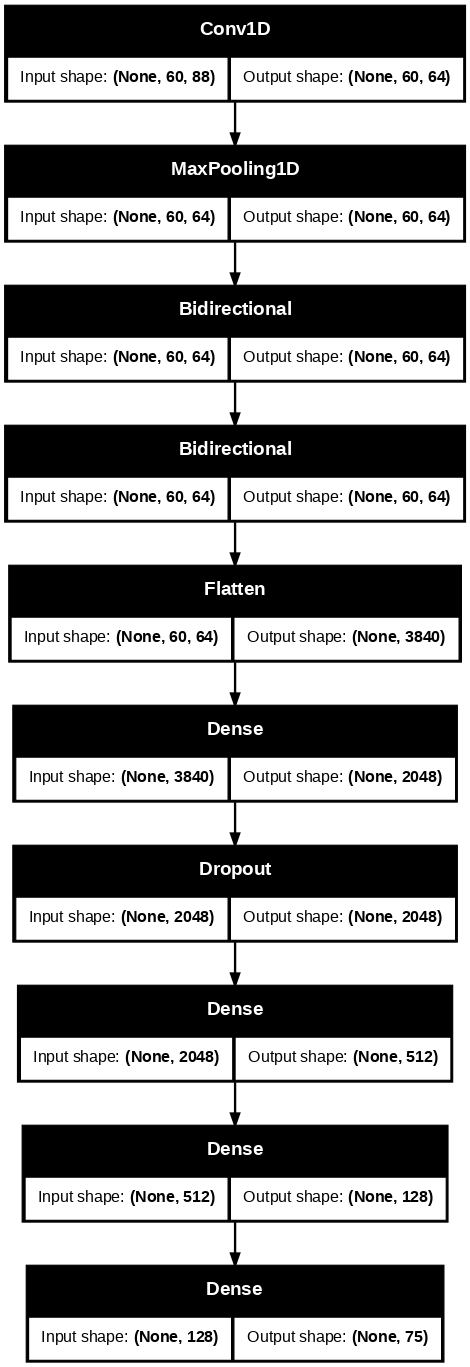

In [74]:
plot_model(model, show_shapes=True, dpi=84)

In [75]:
model.compile(optimizer='adam', loss=smape, metrics=['mae'])

In [76]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 135.7675 - mae: 1.1299
Epoch 1: val_loss improved from inf to 119.39767, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 135.5059 - mae: 1.1281 - val_loss: 119.3977 - val_mae: 1.0346 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 114.7303 - mae: 0.8724
Epoch 2: val_loss improved from 119.39767 to 110.97188, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - loss: 114.6525 - mae: 0.8713 - val_loss: 110.9719 - val_mae: 0.9841 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 104.7606 - mae: 0.7483
Epoch 3: val_loss improved from 110.97188 to 101.30717, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 104.7084 - mae: 0.7476 - val_loss: 101.3072 - val_mae: 0.8687 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 97.8566 - mae: 0.6551
Epoch 4: val_loss improved from 101.30717 to 88.80873, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 97.8438 - mae: 0.6549 - val_loss: 88.8087 - val_mae: 0.7653 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 95.9419 - mae: 0.6462
Epoch 5: val_loss did not improve from 88.80873
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 95.8658 - mae: 0.6450 - val_loss: 91.4419 - val_mae: 0.7408 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 89.4569 - mae: 0.5627
Epoch 6: val_loss improved from 88.80873 to 88.11632, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - loss: 89.4054 - mae: 0.5621 - val_loss: 88.1163 - val_mae: 0.6958 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 85.7625 - mae: 0.5160
Epoch 7: val_loss improved from 88.11632 to 80.32007, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - loss: 85.6981 - mae: 0.5156 - val_loss: 80.3201 - val_mae: 0.6650 - learning_rate: 0.0010
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 85.0916 - mae: 0.5173
Epoch 8: val_loss did not improve from 80.32007
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 85.0157 - mae: 0.5166 - val_loss: 96.1100 - val_mae: 0.7543 - learning_rate: 0.0010
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 78.1989 - mae: 0.4485
Epoch 9: val_loss did not improve from 80.32007
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 78.1499 - mae: 0.4482 - val_loss: 80.5758 - val_mae: 0.6389 - learning_rate: 0.0010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 73.6153 - mae: 0.4120
Epoch 10: val_loss did not improve from 80.32007
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 73.6284 - mae: 0.4122 - val_loss: 89.0651 - val_mae: 0.7232 - learning_rate: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 73.4822 - ma

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 66.0678 - mae: 0.3442 - val_loss: 79.5862 - val_mae: 0.6020 - learning_rate: 5.0000e-04
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 65.2508 - mae: 0.3472
Epoch 16: val_loss did not improve from 79.58623
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 65.2644 - mae: 0.3472 - val_loss: 82.6717 - val_mae: 0.6326 - learning_rate: 5.0000e-04
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 64.1801 - mae: 0.3372
Epoch 17: val_loss did not improve from 79.58623
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - loss: 64.1989 - mae: 0.3372 - val_loss: 82.6666 - val_mae: 0.6295 - learning_rate: 5.0000e-04
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 64.7991 - mae: 0.3402
Epoch 18: val_loss did not improve from 79.58623
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 64.8002 - mae: 0.3401 - val_loss: 81.1208 - val_mae: 0.6208 - learning_rate: 5.0000e-04
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step 

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 62.3671 - mae: 0.3214 - val_loss: 78.6997 - val_mae: 0.5938 - learning_rate: 2.5000e-04
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 62.3024 - mae: 0.3187
Epoch 25: val_loss did not improve from 78.69968
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 62.3074 - mae: 0.3188 - val_loss: 81.6156 - val_mae: 0.6193 - learning_rate: 2.5000e-04
Epoch 26/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 61.4248 - mae: 0.3173
Epoch 26: val_loss did not improve from 78.69968
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 61.4469 - mae: 0.3174 - val_loss: 81.2598 - val_mae: 0.6105 - learning_rate: 2.5000e-04
Epoch 27/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 61.6322 - mae: 0.3131
Epoch 27: val_loss did not improve from 78.69968
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - loss: 61.6388 - mae: 0.3132 - val_loss: 81.5055 - val_mae: 0.6173 - learning_rate: 2.5000e-04
Epoch 28/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step -

## 5.0 Evaluation

### 5.1 CNN-LSTM model evaluation

In [77]:
y_pred_test = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


In [78]:
def smape_np(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true)
    return np.mean(200.0 * diff / (denominator + 1e-8))

In [79]:
test_smape = smape_np(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

In [80]:
print(f"Test SMAPE: {test_smape:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Test SMAPE: 93.41
Test MAE: 0.63


## 6.0 Deployment

### 6.1 Generate rolling forecast

In [81]:
initial_sequence = test_df[-60:].values

In [82]:
forecast = []
current_seq = initial_sequence.copy()

In [83]:
calendar_columns = train_df.columns[-13:]

In [84]:
calendar_columns

Index(['year', 'month', 'day', 'week', 'dayofweek', 'dayofyear', 'quarter',
       'is_weekend', 'Argentina holiday', 'Canada holiday', 'Estonia holiday',
       'Japan holiday', 'Spain holiday'],
      dtype='object')

In [85]:
calendar_df = pd.DataFrame({'date': df_test['date'].unique()})

In [86]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [87]:
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['day'] = calendar_df['date'].dt.day
calendar_df['week'] = calendar_df['date'].dt.isocalendar().week
calendar_df['dayofweek'] = calendar_df['date'].dt.dayofweek
calendar_df['dayofyear'] = calendar_df['date'].dt.dayofyear
calendar_df['quarter'] = calendar_df['date'].dt.quarter
calendar_df['is_weekend'] = calendar_df['dayofweek'] > 4

In [88]:
for country in ['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']:
    calendar_df[country + ' holiday'] = calendar_df['date'].isin(
        holidays.CountryHoliday(country, years=2022)
    )

In [89]:
calendar_df = calendar_df.drop(columns=['date'])

In [90]:
calendar_df = calendar_df.astype(int)

In [91]:
calendar_df

,year,month,day,week,dayofweek,dayofyear,quarter,is_weekend,Argentina holiday,Canada holiday,Estonia holiday,Japan holiday,Spain holiday
0,2022,1,1,52,5,1,1,1,1,1,1,1,1
1,2022,1,2,52,6,2,1,1,0,0,0,0,0
2,2022,1,3,1,0,3,1,0,0,1,0,0,0
3,2022,1,4,1,1,4,1,0,0,0,0,0,0
4,2022,1,5,1,2,5,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022,12,27,52,1,361,4,0,0,0,0,0,0
361,2022,12,28,52,2,362,4,0,0,0,0,0,0
362,2022,12,29,52,3,363,4,0,0,0,0,0,0
363,2022,12,30,52,4,364,4,0,0,0,0,0,0


In [92]:
calendar_scaler = StandardScaler()

In [93]:
calendar_2022 = calendar_scaler.fit_transform(calendar_df[calendar_columns])

In [94]:
for i in range(365):
    pred = model.predict(current_seq.reshape(1, 60, 88))  # shape: (1, 75)
    forecast.append(pred[0])
    next_calendar_features = calendar_2022[i]  # shape: (13,)
    next_input = np.concatenate([pred[0], next_calendar_features])
    current_seq = np.append(current_seq[1:], next_input.reshape(1, 88), axis=0)

forecast_array = np.array(forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

### 6.2 Generate submission

#### 6.2.1 Prepare forecast

In [95]:
submission = df_test.copy()

In [96]:
scale_inv = StandardScaler()

In [97]:
raw_train_df

,Argentina Kaggle Learn product_0,Argentina Kaggle Learn product_1,Argentina Kaggle Learn product_2,Argentina Kaggle Learn product_3,Argentina Kaggle Learn product_4,Argentina Kaggle Store product_0,Argentina Kaggle Store product_1,Argentina Kaggle Store product_2,Argentina Kaggle Store product_3,Argentina Kaggle Store product_4,Argentina Kagglazon product_0,Argentina Kagglazon product_1,Argentina Kagglazon product_2,Argentina Kagglazon product_3,Argentina Kagglazon product_4,Canada Kaggle Learn product_0,Canada Kaggle Learn product_1,Canada Kaggle Learn product_2,Canada Kaggle Learn product_3,Canada Kaggle Learn product_4,Canada Kaggle Store product_0,Canada Kaggle Store product_1,Canada Kaggle Store product_2,Canada Kaggle Store product_3,Canada Kaggle Store product_4,Canada Kagglazon product_0,Canada Kagglazon product_1,Canada Kagglazon product_2,Canada Kagglazon product_3,Canada Kagglazon product_4,Estonia Kaggle Learn product_0,Estonia Kaggle Learn product_1,Estonia Kaggle Learn product_2,Estonia Kaggle Learn product_3,Estonia Kaggle Learn product_4,Estonia Kaggle Store product_0,Estonia Kaggle Store product_1,Estonia Kaggle Store product_2,Estonia Kaggle Store product_3,Estonia Kaggle Store product_4,Estonia Kagglazon product_0,Estonia Kagglazon product_1,Estonia Kagglazon product_2,Estonia Kagglazon product_3,Estonia Kagglazon product_4,Japan Kaggle Learn product_0,Japan Kaggle Learn product_1,Japan Kaggle Learn product_2,Japan Kaggle Learn product_3,Japan Kaggle Learn product_4,Japan Kaggle Store product_0,Japan Kaggle Store product_1,Japan Kaggle Store product_2,Japan Kaggle Store product_3,Japan Kaggle Store product_4,Japan Kagglazon product_0,Japan Kagglazon product_1,Japan Kagglazon product_2,Japan Kagglazon product_3,Japan Kagglazon product_4,Spain Kaggle Learn product_0,Spain Kaggle Learn product_1,Spain Kaggle Learn product_2,Spain Kaggle Learn product_3,Spain Kaggle Learn product_4,Spain Kaggle Store product_0,Spain Kaggle Store product_1,Spain Kaggle Store product_2,Spain Kaggle Store product_3,Spain Kaggle Store product_4,Spain Kagglazon product_0,Spain Kagglazon product_1,Spain Kagglazon product_2,Spain Kagglazon product_3,Spain Kagglazon product_4,year,month,day,week,dayofweek,dayofyear,quarter,is_weekend,Argentina holiday,Canada holiday,Estonia holiday,Japan holiday,Spain holiday
0,63,66,9,59,49,88,98,14,83,69,340,371,53,364,285,202,199,31,202,138,274,288,47,268,249,1041,1101,166,1062,866,92,89,14,81,70,132,129,19,137,106,501,481,70,468,383,167,162,26,163,119,270,246,39,266,191,938,869,147,970,701,122,125,20,106,90,177,198,29,184,139,724,681,107,673,520,2017,1,1,6,6,1,6,True,True,True,True,True,False
1,51,47,7,43,35,74,77,11,70,55,250,273,52,236,206,156,150,26,158,123,253,240,46,252,205,870,930,141,814,717,63,65,10,64,50,109,102,15,88,80,353,347,64,366,286,142,146,19,121,93,210,192,30,180,146,728,703,105,621,547,106,100,13,94,68,145,140,22,125,110,541,546,78,481,381,2017,1,2,0,0,2,0,False,False,True,False,True,False
2,44,45,7,41,37,64,68,11,67,56,267,253,35,252,201,147,155,26,149,123,235,240,38,222,187,875,967,135,830,720,64,63,10,60,50,105,92,15,89,72,354,355,56,310,289,123,118,18,120,98,191,176,31,164,150,673,631,115,640,494,85,90,14,80,60,161,133,20,118,106,499,489,80,509,372,2017,1,3,1,1,3,1,False,False,False,False,False,False
3,44,42,7,40,32,72,66,10,64,49,236,243,34,224,194,158,169,24,137,113,236,244,40,224,179,799,895,122,751,619,64,61,9,58,49,93,99,15,94,75,376,369,57,315,251,124,122,18,108,97,176,186,29,159,141,719,688,93,635,489,79,76,13,69,69,128,121,19,126,99,524,485,70,435,367,2017,1,4,2,2,4,2,False,False,False,False,False,False
4,40,46,6,39,32,66,61,10,64,50,247,231,38,207,179,140,139,24,138,117,239,253,35,214,185,837,817,134,762,595,60,62,9,54,45,97,90,13,80,78,360,342,52,324,254,116,113,17,104,90,160,186,30,163,138,616,672,101,592,511,80,83,12,77,60,122,129,20,118,104,469,478,69,444,344,2017,1,5,3,3,5,3,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,

In [98]:
forecast_array

array([[ 0.10106656, -0.01332361, -0.22834104, ...,  1.6072134 ,
         2.0734096 ,  1.2116141 ],
       [ 0.38354495,  0.20967314, -0.04940639, ...,  2.2087288 ,
         2.7528434 ,  1.6582088 ],
       [-0.5244248 , -0.5697633 , -0.7255673 , ...,  0.4862086 ,
         1.1935052 ,  0.70449   ],
       ...,
       [-0.59084487, -0.90538853, -1.3414847 , ...,  1.0182204 ,
         1.6240773 ,  0.03677312],
       [-0.34597293, -0.7600207 , -1.0763342 , ...,  1.3313302 ,
         1.8526249 ,  0.19680601],
       [-0.17463046, -0.6846934 , -0.96759504, ...,  1.5301495 ,
         2.018495  ,  0.29701295]], dtype=float32)

In [99]:
scale_inv.fit(raw_train_df.iloc[:, :75])

StandardScaler()

In [100]:
forecast_array_real = scale_inv.inverse_transform(forecast_array)

In [101]:
forecast_array_real

array([[ 33.766296 ,  32.385067 ,   4.4579806, ...,  84.72591  ,
        504.1724   , 424.65164  ],
       [ 35.854424 ,  33.819115 ,   4.6520753, ...,  90.15375  ,
        544.815    , 453.65707  ],
       [ 29.142563 ,  28.806717 ,   3.9186282, ...,  74.61039  ,
        451.53796  , 391.71497  ],
       ...,
       [ 28.651575 ,  26.648378 ,   3.250529 , ...,  79.411064 ,
        477.29407  , 348.3481   ],
       [ 30.461708 ,  27.58321  ,   3.5381436, ...,  82.23644  ,
        490.96542  , 358.74194  ],
       [ 31.728298 ,  28.067623 ,   3.6560955, ...,  84.03051  ,
        500.8875   , 365.25015  ]], dtype=float32)

In [102]:
forecast_array_real = np.clip(forecast_array_real, 0, None)

In [103]:
forecast_array_real = np.round(forecast_array_real).astype(int)

#### 6.2.2 Plot forecast

In [112]:
df_date

,date,Argentina Kaggle Learn product_0,Argentina Kaggle Learn product_1,Argentina Kaggle Learn product_2,Argentina Kaggle Learn product_3,Argentina Kaggle Learn product_4,Argentina Kaggle Store product_0,Argentina Kaggle Store product_1,Argentina Kaggle Store product_2,Argentina Kaggle Store product_3,Argentina Kaggle Store product_4,Argentina Kagglazon product_0,Argentina Kagglazon product_1,Argentina Kagglazon product_2,Argentina Kagglazon product_3,Argentina Kagglazon product_4,Canada Kaggle Learn product_0,Canada Kaggle Learn product_1,Canada Kaggle Learn product_2,Canada Kaggle Learn product_3,Canada Kaggle Learn product_4,Canada Kaggle Store product_0,Canada Kaggle Store product_1,Canada Kaggle Store product_2,Canada Kaggle Store product_3,Canada Kaggle Store product_4,Canada Kagglazon product_0,Canada Kagglazon product_1,Canada Kagglazon product_2,Canada Kagglazon product_3,Canada Kagglazon product_4,Estonia Kaggle Learn product_0,Estonia Kaggle Learn product_1,Estonia Kaggle Learn product_2,Estonia Kaggle Learn product_3,Estonia Kaggle Learn product_4,Estonia Kaggle Store product_0,Estonia Kaggle Store product_1,Estonia Kaggle Store product_2,Estonia Kaggle Store product_3,Estonia Kaggle Store product_4,Estonia Kagglazon product_0,Estonia Kagglazon product_1,Estonia Kagglazon product_2,Estonia Kagglazon product_3,Estonia Kagglazon product_4,Japan Kaggle Learn product_0,Japan Kaggle Learn product_1,Japan Kaggle Learn product_2,Japan Kaggle Learn product_3,Japan Kaggle Learn product_4,Japan Kaggle Store product_0,Japan Kaggle Store product_1,Japan Kaggle Store product_2,Japan Kaggle Store product_3,Japan Kaggle Store product_4,Japan Kagglazon product_0,Japan Kagglazon product_1,Japan Kagglazon product_2,Japan Kagglazon product_3,Japan Kagglazon product_4,Spain Kaggle Learn product_0,Spain Kaggle Learn product_1,Spain Kaggle Learn product_2,Spain Kaggle Learn product_3,Spain Kaggle Learn product_4,Spain Kaggle Store product_0,Spain Kaggle Store product_1,Spain Kaggle Store product_2,Spain Kaggle Store product_3,Spain Kaggle Store product_4,Spain Kagglazon product_0,Spain Kagglazon product_1,Spain Kagglazon product_2,Spain Kagglazon product_3,Spain Kagglazon product_4,year,month,day,week,dayofweek,dayofyear,quarter,is_weekend,Argentina holiday,Canada holiday,Estonia holiday,Japan holiday,Spain holiday
0,2017-01-01,63,66,9,59,49,88,98,14,83,69,340,371,53,364,285,202,199,31,202,138,274,288,47,268,249,1041,1101,166,1062,866,92,89,14,81,70,132,129,19,137,106,501,481,70,468,383,167,162,26,163,119,270,246,39,266,191,938,869,147,970,701,122,125,20,106,90,177,198,29,184,139,724,681,107,673,520,2017,1,1,6,6,1,6,True,True,True,True,True,False
1,2017-01-02,51,47,7,43,35,74,77,11,70,55,250,273,52,236,206,156,150,26,158,123,253,240,46,252,205,870,930,141,814,717,63,65,10,64,50,109,102,15,88,80,353,347,64,366,286,142,146,19,121,93,210,192,30,180,146,728,703,105,621,547,106,100,13,94,68,145,140,22,125,110,541,546,78,481,381,2017,1,2,0,0,2,0,False,False,True,False,True,False
2,2017-01-03,44,45,7,41,37,64,68,11,67,56,267,253,35,252,201,147,155,26,149,123,235,240,38,222,187,875,967,135,830,720,64,63,10,60,50,105,92,15,89,72,354,355,56,310,289,123,118,18,120,98,191,176,31,164,150,673,631,115,640,494,85,90,14,80,60,161,133,20,118,106,499,489,80,509,372,2017,1,3,1,1,3,1,False,False,False,False,False,False
3,2017-01-04,44,42,7,40,32,72,66,10,64,49,236,243,34,224,194,158,169,24,137,113,236,244,40,224,179,799,895,122,751,619,64,61,9,58,49,93,99,15,94,75,376,369,57,315,251,124,122,18,108,97,176,186,29,159,141,719,688,93,635,489,79,76,13,69,69,128,121,19,126,99,524,485,70,435,367,2017,1,4,2,2,4,2,False,False,False,False,False,False
4,2017-01-05,40,46,6,39,32,66,61,10,64,50,247,231,38,207,179,140,139,24,138,117,239,253,35,214,185,837,817,134,762,595,60,62,9,54,45,97,90,13,80,78,360,342,52,324,254,116,113,17,104,90,160,186,30,163,138,616,672,101,592,511,80,83,12,77,60,122,129,20,118,104,469,478,69,444,344,2017,1,5,3,3,5,3,False,False,False,False,Fals

In [114]:
forecast_dates = pd.date_range(start="2022-01-01", periods=len(forecast_array), freq='D')

In [118]:
forecast_total = forecast_array_real.sum(axis=1)

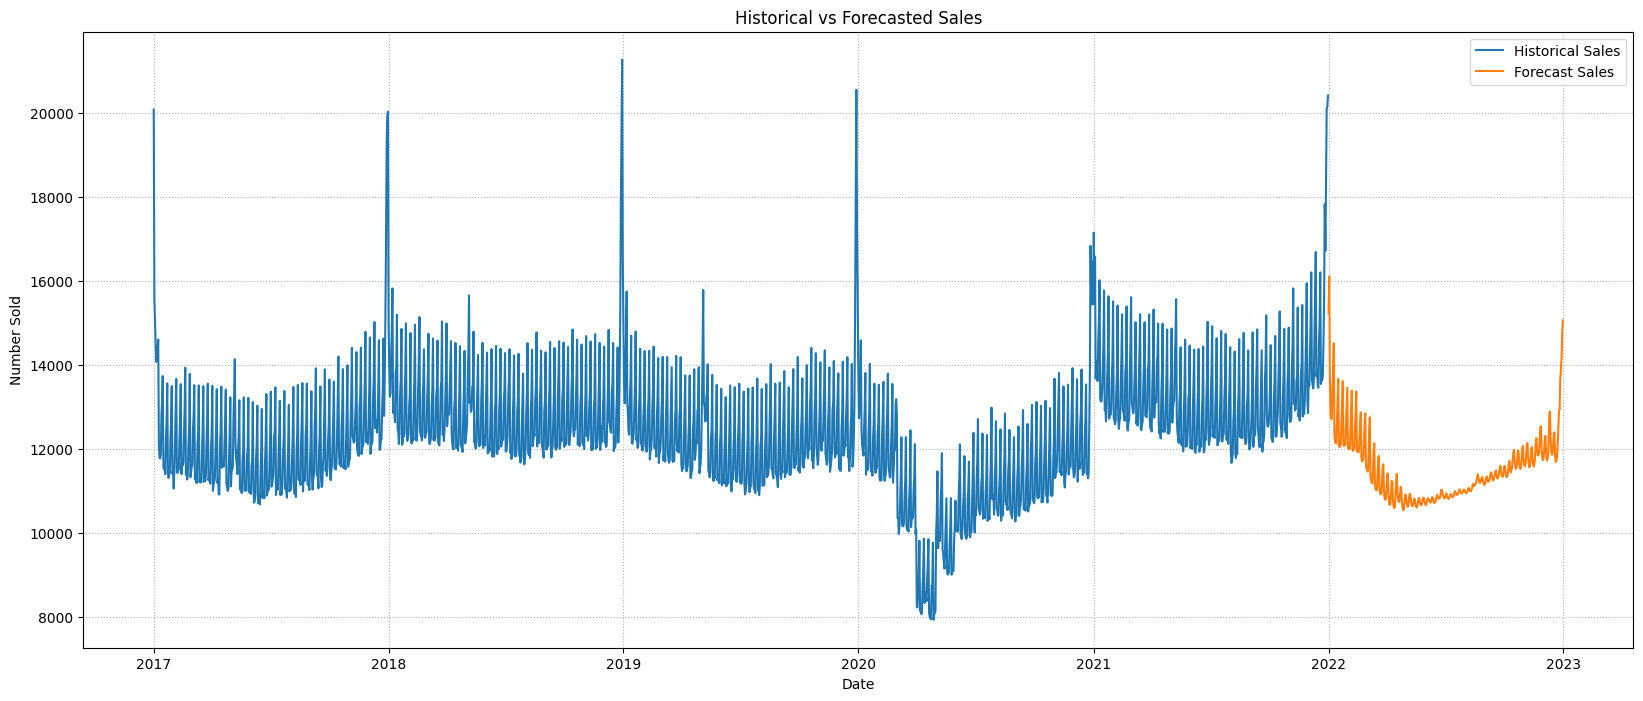

In [119]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(x=df_aux.index, y=df_aux, errorbar=None, label="Historical Sales")
sns.lineplot(x=forecast_dates, y=forecast_total, errorbar=None, label="Forecast Sales")
plt.grid(linestyle=":")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.title("Historical vs Forecasted Sales")
plt.show()

#### 6.2.3 Prepare submission

In [120]:
df_test["num_sold"] = 0

In [121]:
p = 0

In [122]:
for country in countries:
    for store in stores:
        for product in products:
            df_test.loc[
                (df_test["country"] == country) &
                (df_test["store"] == store) &
                (df_test["product"] == product),
                "num_sold"
            ] = np.round(forecast_array_real[:, p]).astype('int32')
            p += 1

In [123]:
df_test

,date,country,store,product,num_sold
id,,,,,
136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,34
136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,32
136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,4
136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,31
136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,24
...,...,...,...,...,...
164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,610
164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,551
164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,84


In [124]:
submission = df_test["num_sold"]

In [125]:
submission.to_csv("submission.csv")

In [126]:
pd.read_csv("submission.csv")

,id,num_sold
0,136950,34
1,136951,32
2,136952,4
3,136953,31
4,136954,24
...,...,...
27370,164320,610
27371,164321,551
27372,164322,84
27373,164323,501


In [127]:
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* Paper: ComfortJDDS8150-3.docx - Convolutional Neural Network and Long Short-term Memory Sales Forecast